<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Diffusion Conditional</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [79]:
import torch;
import torchvision
import numpy as np
import torch.utils
import torch.distributions

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from tqdm import tqdm
torch.manual_seed(0)

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Loading Data</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [80]:
# Composed transforms
trs = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),  torchvision.transforms.Pad(2)])

# Load the data
data_train = torchvision.datasets.MNIST('./data', transform=trs, download=True, train=True)

# Create the data loader
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle= True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11648591.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346759.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3250757.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8340861.98it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



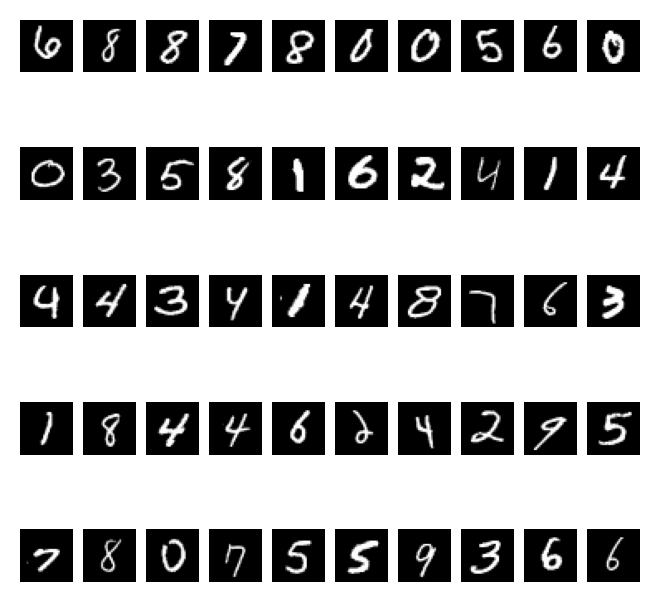

In [81]:
# Displaying a 5 by 5 plot of image samples
data, cls = next(iter(train_loader))
plt.figure(figsize = (4, 4))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')

<hr style="color:#5A7D9F;">
<p align="center">
<b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
<center>Architecture - Diffusion UNET</center>
</b>
</p>
<hr style="color:#5A7D9F;">

In [82]:
# --- #
def time_encoding(time: torch.Tensor, frequencies:int = 128):
    r"""Encoding the time using the "Attention is all you need" paper encoding scheme"""

    # Security
    with torch.no_grad():

        # Encoding functions
        sinusoidal   = lambda time, frequency_index, frequencies: torch.sin(time / (10000 ** (frequency_index / frequencies)))
        cosinusoidal = lambda time, frequency_index, frequencies: torch.cos(time / (10000 ** (frequency_index / frequencies)))

        # Storing the encoding
        encoded_time = torch.zeros(time.shape[0], time.shape[1], frequencies * 2)

        # Mapping time to its encoding
        for b_index, b in enumerate(time):
            for t_index, t in enumerate(b):

                # Stores the current encoding
                encoding = list()

                # Computing the encoding, i.e. alternating between sinusoidal and cosinusoidal encoding
                for i in range(frequencies):
                    encoding += [sinusoidal(t, i, frequencies), cosinusoidal(t, i, frequencies)]

                # Conversion to torch tensor and storing the encoding
                encoded_time[b_index, t_index, :] =  torch.FloatTensor(encoding).clone()

        return encoded_time

class LayerNormalization(nn.Module):
    r"""Custom Layer Normalization module"""

    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.dim = dim

    def forward(self, x: torch.Tensor):
        var, mean = torch.var_mean(x, dim = self.dim, keepdim = True)
        return (x - mean)/torch.sqrt(var + self.eps)

class TimeResidual_Block(nn.Module):
    r"""A time residual block for UNET"""

    def __init__(self, input_channels: int, frequencies: int):
        super(TimeResidual_Block, self).__init__()

        # Initializations
        self.frequencies   = frequencies
        self.activation    = nn.SiLU()
        self.normalization = LayerNormalization(dim = 1)
        self.variance      = torch.sqrt(torch.tensor(2))

        # Temporal Projection
        self.time_projection = nn.Linear(in_features = self.frequencies * 2, out_features = input_channels, bias = False)

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels  = input_channels,
                               out_channels = input_channels,
                               kernel_size  = 3,
                               stride       = 1,
                               padding      = 1)

        self.conv2 = nn.Conv2d(in_channels  = input_channels,
                               out_channels = input_channels,
                               kernel_size  = 3,
                               stride       = 1,
                               padding      = 1)

    def forward(self, x, time):

        # -------------------
        #        Time
        # -------------------
        # 1. Initial information
        b, c, x_res, y_res = x.shape

        # 2. Temporal Projection
        encoded_time = self.time_projection(time)
        encoded_time = self.activation(encoded_time)

        # 3. Reshaping the time encoding
        encoded_time = encoded_time[:, :, None, None]

        # -------------------
        #        Spatial
        # -------------------
        # 1. Adding temporal information (broadcasting)
        x_residual = x + encoded_time

        # 2. Normalization
        x_residual = self.normalization(x_residual)

        # 3. Convolution (1)
        x_residual = self.conv1(x_residual)

        # 4. Activation
        x_residual = self.activation(x_residual)

        # 5. Convolution (2)
        x_residual = self.conv2(x_residual)

        # 6. Adding the residual
        x = x + x_residual

        # 7. Keeping unit variance
        return x / self.variance

    def count_parameters(self,):
        r"""Determines the number of trainable parameters in the model"""
        return int(sum(p.numel() for p in self.parameters() if p.requires_grad))

class TimeResidual_UNET(nn.Module):
    r"""A time residual UNET for time series forecasting"""

    def __init__(self, input_channels: int, output_channels: int, frequencies: int, scaling: int = 1):
        super(TimeResidual_UNET, self).__init__()

        # Initializations
        self.frequencies      = frequencies
        self.input_channels   = input_channels
        self.output_channels  = output_channels

        # 1. Input (lifting)
        self.input_conv = nn.Conv2d(in_channels = self.input_channels, out_channels = 32 * scaling, kernel_size = 3, stride = 1, padding = 1)

        # 2. Downsampling
        #
        # Time Residual Blocks (1)
        self.downsample_11_residuals = TimeResidual_Block(input_channels  = 32 * scaling,     frequencies = self.frequencies)
        self.downsample_12_residuals = TimeResidual_Block(input_channels  = 32 * scaling,     frequencies = self.frequencies)
        self.downsample_21_residuals = TimeResidual_Block(input_channels  = 32 * scaling * 2, frequencies = self.frequencies)
        self.downsample_22_residuals = TimeResidual_Block(input_channels  = 32 * scaling * 2, frequencies = self.frequencies)
        self.downsample_31_residuals = TimeResidual_Block(input_channels  = 32 * scaling * 4, frequencies = self.frequencies)
        self.downsample_32_residuals = TimeResidual_Block(input_channels  = 32 * scaling * 4, frequencies = self.frequencies)
        self.downsample_41_residuals = TimeResidual_Block(input_channels  = 32 * scaling * 8, frequencies = self.frequencies)
        self.downsample_42_residuals = TimeResidual_Block(input_channels  = 32 * scaling * 8, frequencies = self.frequencies)

        # Convolutions (downsampling)
        self.downsample_1_conv = nn.Conv2d(in_channels = 32 * scaling,     out_channels = 32 * scaling * 2, kernel_size = 2, stride = 2)
        self.downsample_2_conv = nn.Conv2d(in_channels = 32 * scaling * 2, out_channels = 32 * scaling * 4, kernel_size = 2, stride = 2)
        self.downsample_3_conv = nn.Conv2d(in_channels = 32 * scaling * 4, out_channels = 32 * scaling * 8, kernel_size = 2, stride = 2)

        # 3. Upsampling
        #
        # Used for upsampling instead of transposed convolutions
        self.upsample = nn.Upsample(scale_factor = (2, 2))

        # Convolutions (projection)
        self.projection_1 = nn.Conv2d(in_channels = 32 * scaling * (8 + 4), out_channels = 32 * scaling * 4, kernel_size = 3, padding = 1)
        self.projection_2 = nn.Conv2d(in_channels = 32 * scaling * (4 + 2), out_channels = 32 * scaling * 2, kernel_size = 3, padding = 1)
        self.projection_3 = nn.Conv2d(in_channels = 32 * scaling * (2 + 1), out_channels = 32 * scaling    , kernel_size = 3, padding = 1)

        # Time Residual Blocks (2)
        self.upsample_11_residuals = TimeResidual_Block(input_channels = 32 * scaling * 4, frequencies = self.frequencies)
        self.upsample_12_residuals = TimeResidual_Block(input_channels = 32 * scaling * 4, frequencies = self.frequencies)
        self.upsample_21_residuals = TimeResidual_Block(input_channels = 32 * scaling * 2, frequencies = self.frequencies)
        self.upsample_22_residuals = TimeResidual_Block(input_channels = 32 * scaling * 2, frequencies = self.frequencies)
        self.upsample_31_residuals = TimeResidual_Block(input_channels = 32 * scaling    , frequencies = self.frequencies)
        self.upsample_32_residuals = TimeResidual_Block(input_channels = 32 * scaling    , frequencies = self.frequencies)

        # 4. Output (We use a linear to mix accross channels, a convolution mix spatially and introduce bias at the corners)
        self.output_linear = nn.Linear(in_features = 32 * scaling, out_features = self.output_channels, bias = False)

        # Normalization
        self.normalization = LayerNormalization(dim = 1)

    def forward(self, x, time):

        # 1. Lifting
        x = self.input_conv(x)

        # 2. Downsampling
        x = self.downsample_11_residuals(x, time)
        x = self.downsample_12_residuals(x, time)

        x1 = self.downsample_1_conv(x)
        x1 = self.downsample_21_residuals(x1, time)
        x1 = self.downsample_22_residuals(x1, time)

        x2 = self.downsample_2_conv(x1)
        x2 = self.downsample_31_residuals(x2, time)
        x2 = self.downsample_32_residuals(x2, time)

        x3 = self.downsample_3_conv(x2)
        x3 = self.downsample_41_residuals(x3, time)
        x3 = self.downsample_42_residuals(x3, time)
        x3 = self.normalization(x3)

        # 3. Upsampling
        x3 = self.normalization(x3) # Good Practice for conditioning the data with diffusion, etc.
        x3 = self.upsample(x3)

        x2 = torch.cat([x3, x2], dim = 1)
        x2 = self.projection_1(x2)
        x2 = self.upsample_11_residuals(x2, time)
        x2 = self.upsample_12_residuals(x2, time)
        x2 = self.normalization(x2)
        x2 = self.upsample(x2)

        x1 = torch.cat([x2, x1], dim = 1)
        x1 = self.projection_2(x1)
        x1 = self.upsample_21_residuals(x1, time)
        x1 = self.upsample_22_residuals(x1, time)
        x1 = self.normalization(x1)
        x1 = self.upsample(x1)

        x = torch.cat([x1, x], dim = 1)
        x = self.projection_3(x)
        x = self.upsample_31_residuals(x, time)
        x = self.upsample_32_residuals(x, time)

        # 4. Output
        x = self.output_linear(torch.permute(x, (0, 2, 3, 1)))

        # 5. Adding separate channels for mean and log(var)
        return torch.permute(x, (0, 3, 1, 2))

    def count_parameters(self,):
        r"""Determines the number of trainable parameters in the model"""
        return int(sum(p.numel() for p in self.parameters() if p.requires_grad))

In [83]:
class Diffusion_UNET(nn.Module):
    r"""A diffusion UNET for time series forecasting"""

    def __init__(self, diffusion_steps: int, diffusion_scheduler: float = 0.01511, diffusion_variance: float = 0.01, scaling: int = 1, frequencies: int = 32, device: str = 'cpu'):
        super(Diffusion_UNET, self).__init__()

        # Initialization
        self.diffusion_steps     = diffusion_steps
        self.diffusion_scheduler = diffusion_scheduler
        self.diffusion_variance  = diffusion_variance
        self.frequencies         = frequencies
        self.device              = device

        # Number of inputs has changed, now its input and conditional
        self.model               = TimeResidual_UNET(input_channels = 2, output_channels = 1, frequencies = self.frequencies, scaling = scaling)

        # Possible diffusion steps
        steps_t = torch.arange(1, self.diffusion_steps + 1, dtype = torch.float32)

        # Computing encoding for time
        self.encoded_steps = time_encoding(steps_t[:, None], self.frequencies)[:, 0]

        # Precomputing constants
        betas  = torch.ones((self.diffusion_steps, 1), dtype = torch.float32) * diffusion_scheduler
        alphas = torch.pow(1 - diffusion_scheduler, steps_t)[:, None]
        self.sqrt_alphas           = torch.sqrt(alphas)
        self.sqrt_one_minus_alphas = torch.sqrt(1 - alphas)

        # Computing constant for diffusion (in front of latent zt and noise predicted)
        self.latent_constant_zt    = 1 / (torch.sqrt(1 - betas))
        self.latent_constant_noise = betas / (torch.sqrt(1 - alphas) * torch.sqrt(1 - betas))

    def generate_latent(self, x, noise, diffusion_steps):
        """Used to generate the latent variable z_t given the input x"""

        # Extracting constants
        sqrt_alphas           = self.sqrt_alphas[diffusion_steps[:, 0]][:, :, None, None].expand(-1, -1, *x.shape[2:])
        sqrt_one_minus_alphas = self.sqrt_one_minus_alphas[diffusion_steps[:, 0]][:, :, None, None].expand(-1, -1, *x.shape[2:])

        # Computing the latent variable z_t
        return sqrt_alphas * x + sqrt_one_minus_alphas * noise

    def predict(self, z, diffusion_steps):
        return self.model(z, self.encoded_steps[diffusion_steps[:,0]].to(self.device))

    def generate_samples(self, steps = None):
        """Used to generate samples from the model"""

        # Libraries
        from tqdm import tqdm
        from time import sleep

        with torch.no_grad():

            # Sampling the initial noise
            zt = torch.normal(0, 1, (10, 1, 32, 32), device = self.device)

            # Pushing to the device
            self.latent_constant_zt    = self.latent_constant_zt.to(self.device)
            self.latent_constant_noise = self.latent_constant_noise.to(self.device)

            # Computing the conditional
            conditioning = torch.linspace(0, 9, 10)[:, None, None, None].to(self.device).expand(-1, 1, 32, 32)

            # Reverse process
            for t in tqdm(range(self.diffusion_steps - 1 if steps == None else steps, 0, -1)):

                # Genereting encoded timesteps
                diffusion_steps = torch.ones(10, 1, dtype=torch.int64) * t

                # Removing the noise
                zt_hat = self.latent_constant_zt[t] * zt - self.latent_constant_noise[t] * self.predict(torch.cat([conditioning, zt], dim = 1), diffusion_steps)

                # Generating noise
                noise = torch.normal(0, 1, zt_hat.shape).to(self.device)

                # Adding a bit of noise for stochasticity but not on the last step
                zt = zt_hat + self.diffusion_variance * noise if t > 1 else zt_hat

            # Returning the generated samples
            return zt

    def count_parameters(self,):
        r"""Determines the number of trainable parameters in the model"""
        return self.model.count_parameters()


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Training</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [84]:
# ------- PARAMETERS
#
# Total steps in diffusion
T = 200

# Diffusion scheduler
beta = 0.0125

# Diffusion variance
diffusion_variance = 0.005

# Number of frequencies for the encoding
frequencies = 128

# Scaling
scaling = 1

# Learning rate
lr = 1e-3

In [85]:
# ------- MODEL
#
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# Loading the architecture
model = Diffusion_UNET(diffusion_steps = T, diffusion_variance = diffusion_variance, scaling = scaling, frequencies = frequencies, device = device)
model.to(device)

# Total number of parameters
nn_params = model.count_parameters()
print("Total number of parameters: ", nn_params/1e6, "M")

# Total number of available GPUs
num_gpus = torch.cuda.device_count()
print("Available GPUs: ", num_gpus)

# Loading the optimizer
optimizer  = optim.Adam(model.parameters(), lr =lr)

Device:  cuda
Total number of parameters:  5.0248 M
Available GPUs:  1


100%|██████████| 469/469 [00:16<00:00, 27.82it/s]


Loss:  0.02337580919265747


100%|██████████| 199/199 [00:00<00:00, 209.44it/s]


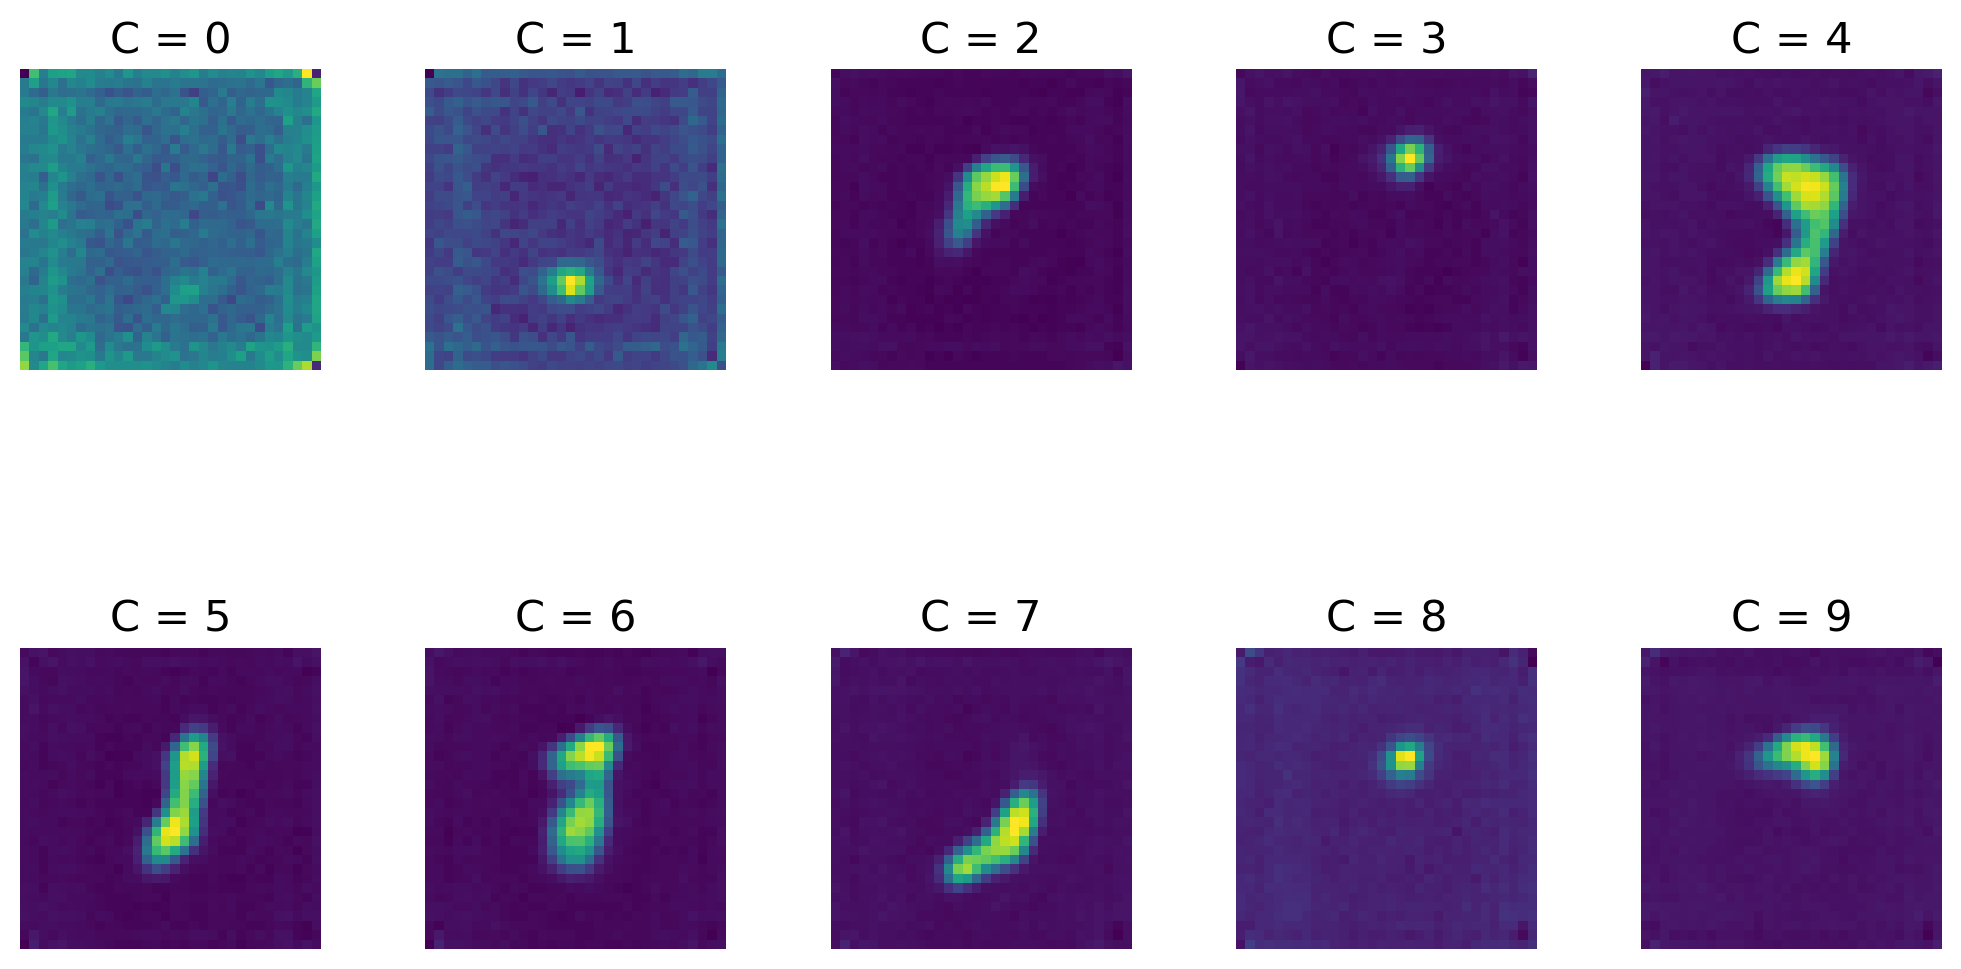

100%|██████████| 469/469 [00:16<00:00, 28.35it/s]


Loss:  0.017319608479738235


100%|██████████| 199/199 [00:00<00:00, 215.11it/s]


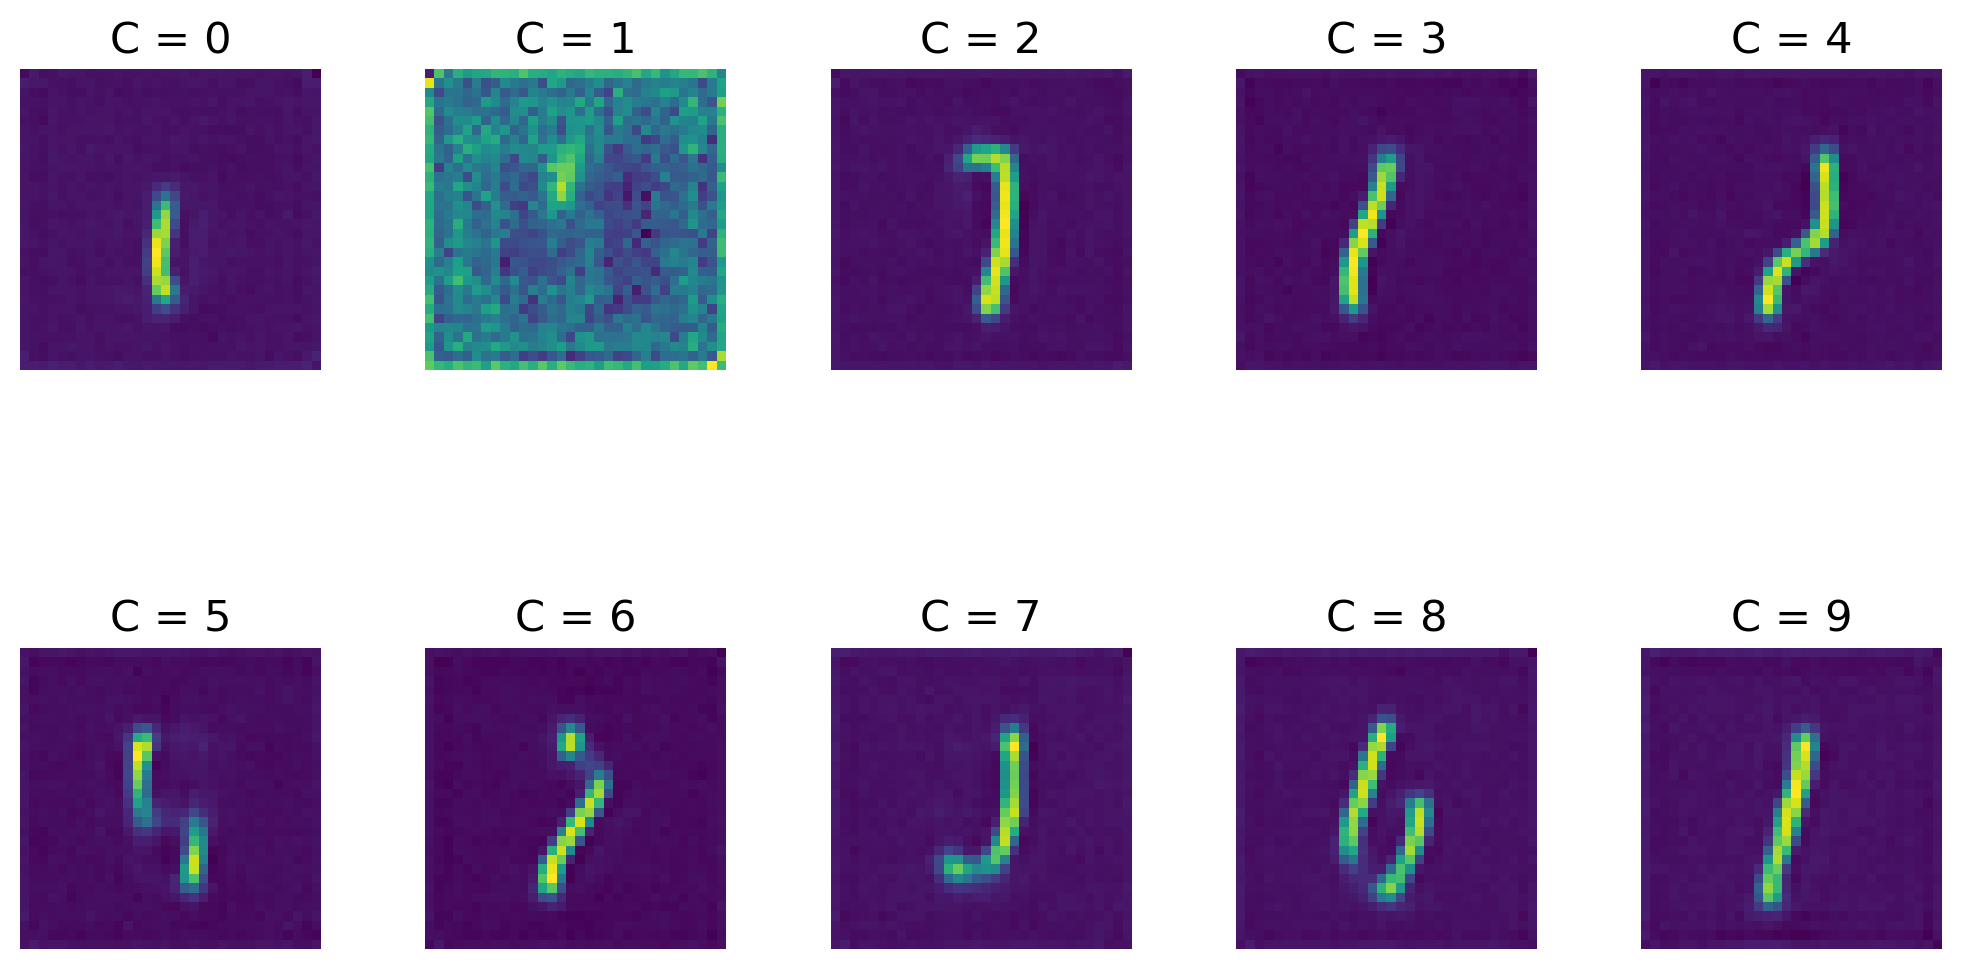

100%|██████████| 469/469 [00:15<00:00, 30.93it/s]


Loss:  0.014090534299612045


100%|██████████| 199/199 [00:00<00:00, 213.64it/s]


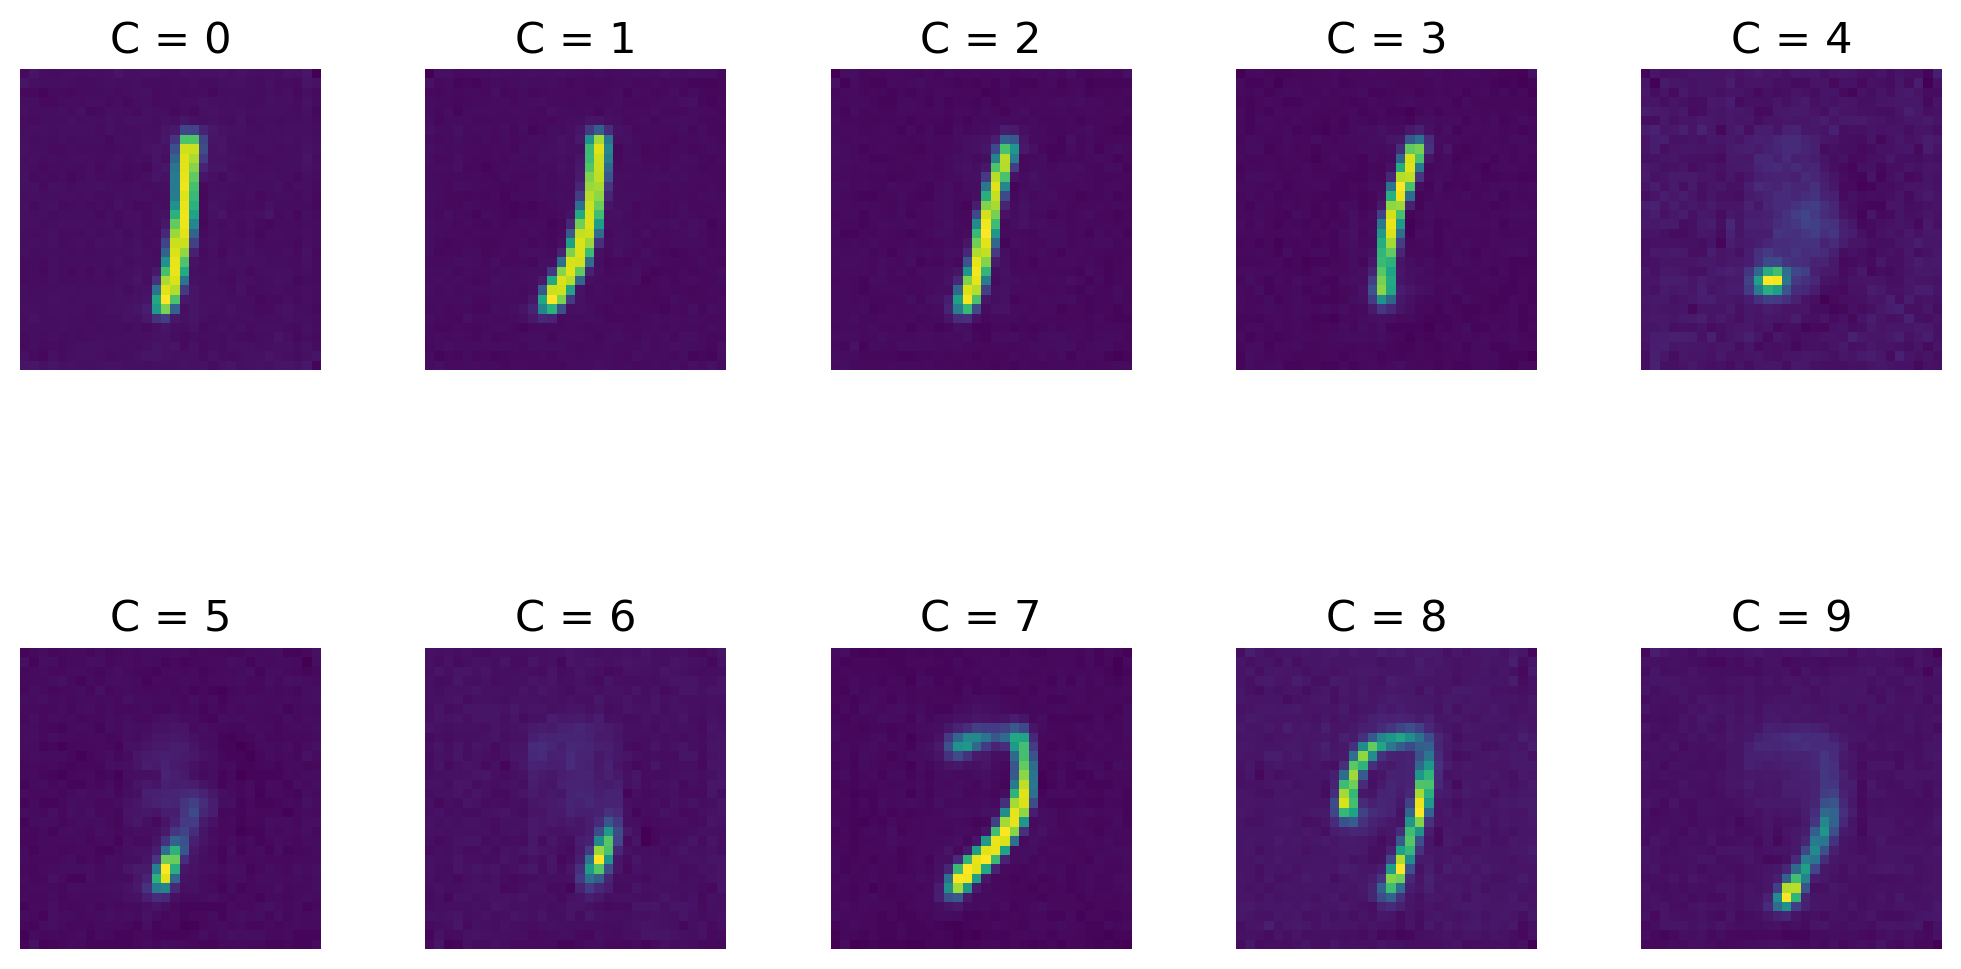

100%|██████████| 469/469 [00:14<00:00, 31.49it/s]


Loss:  0.013578060083091259


100%|██████████| 199/199 [00:00<00:00, 214.80it/s]


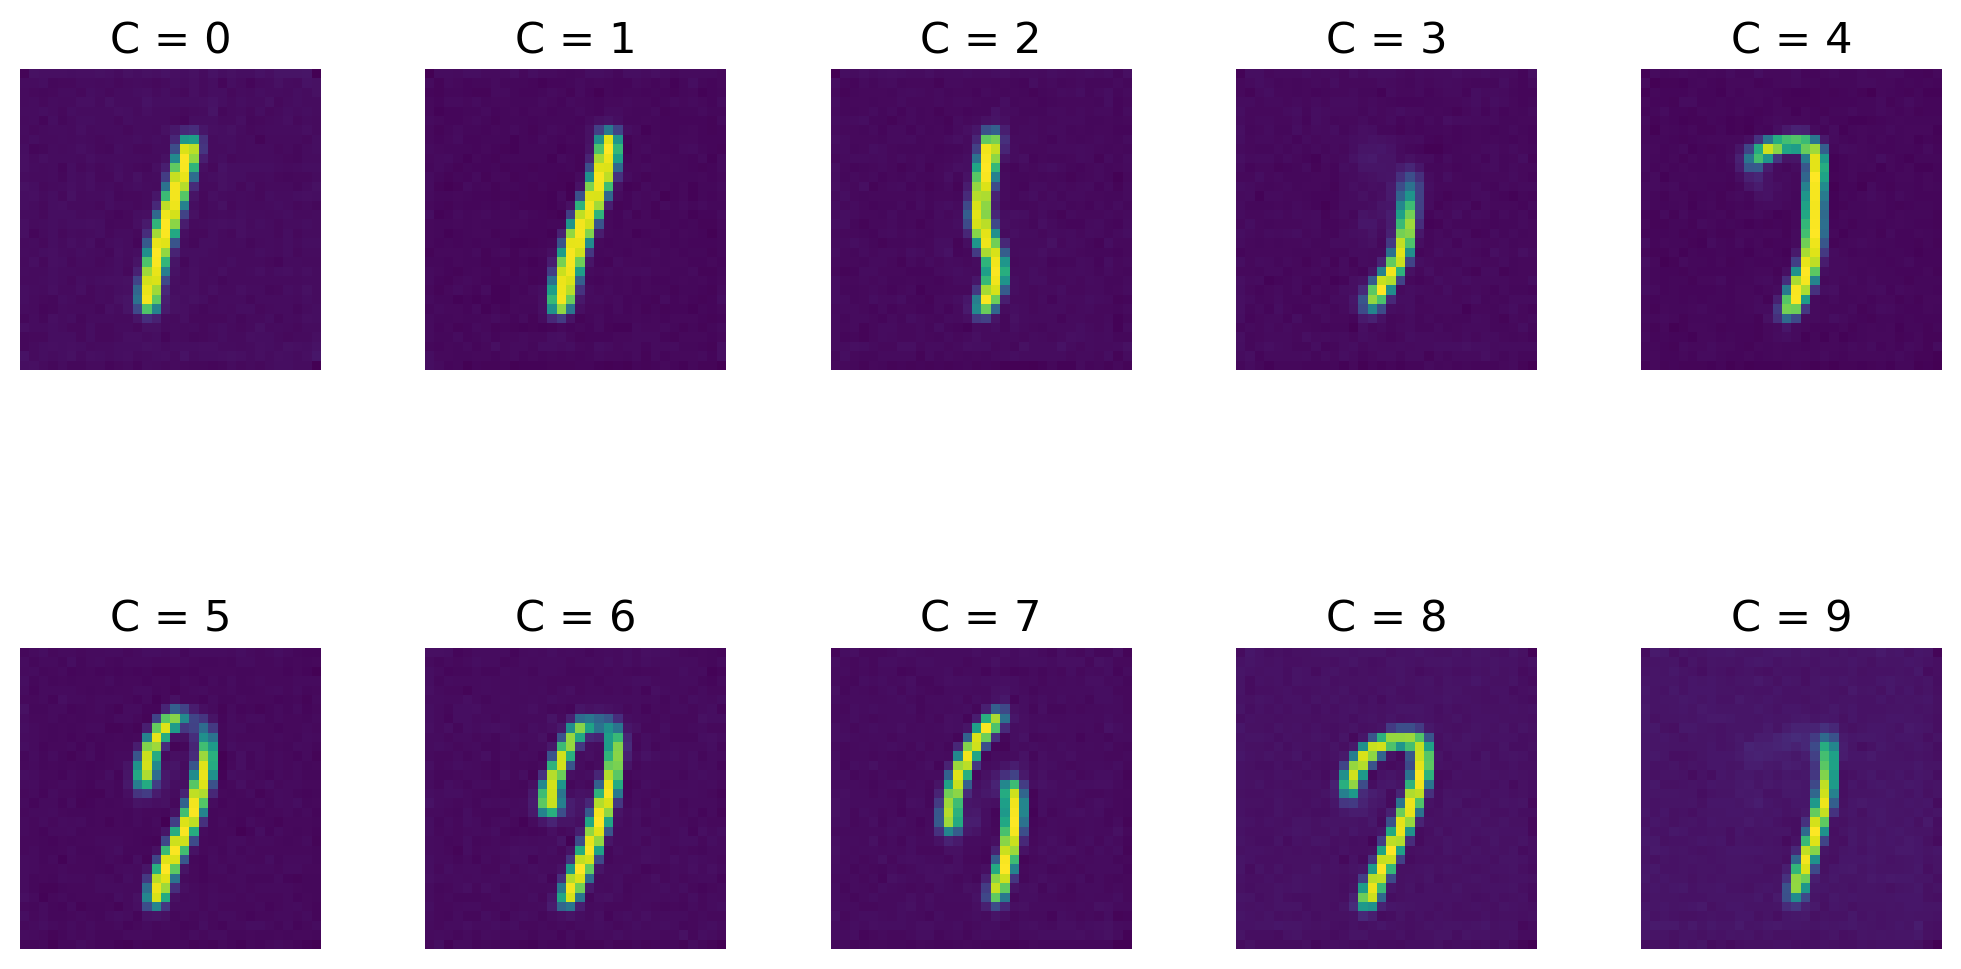

100%|██████████| 469/469 [00:15<00:00, 31.18it/s]


Loss:  0.013593452982604504


100%|██████████| 199/199 [00:00<00:00, 201.52it/s]


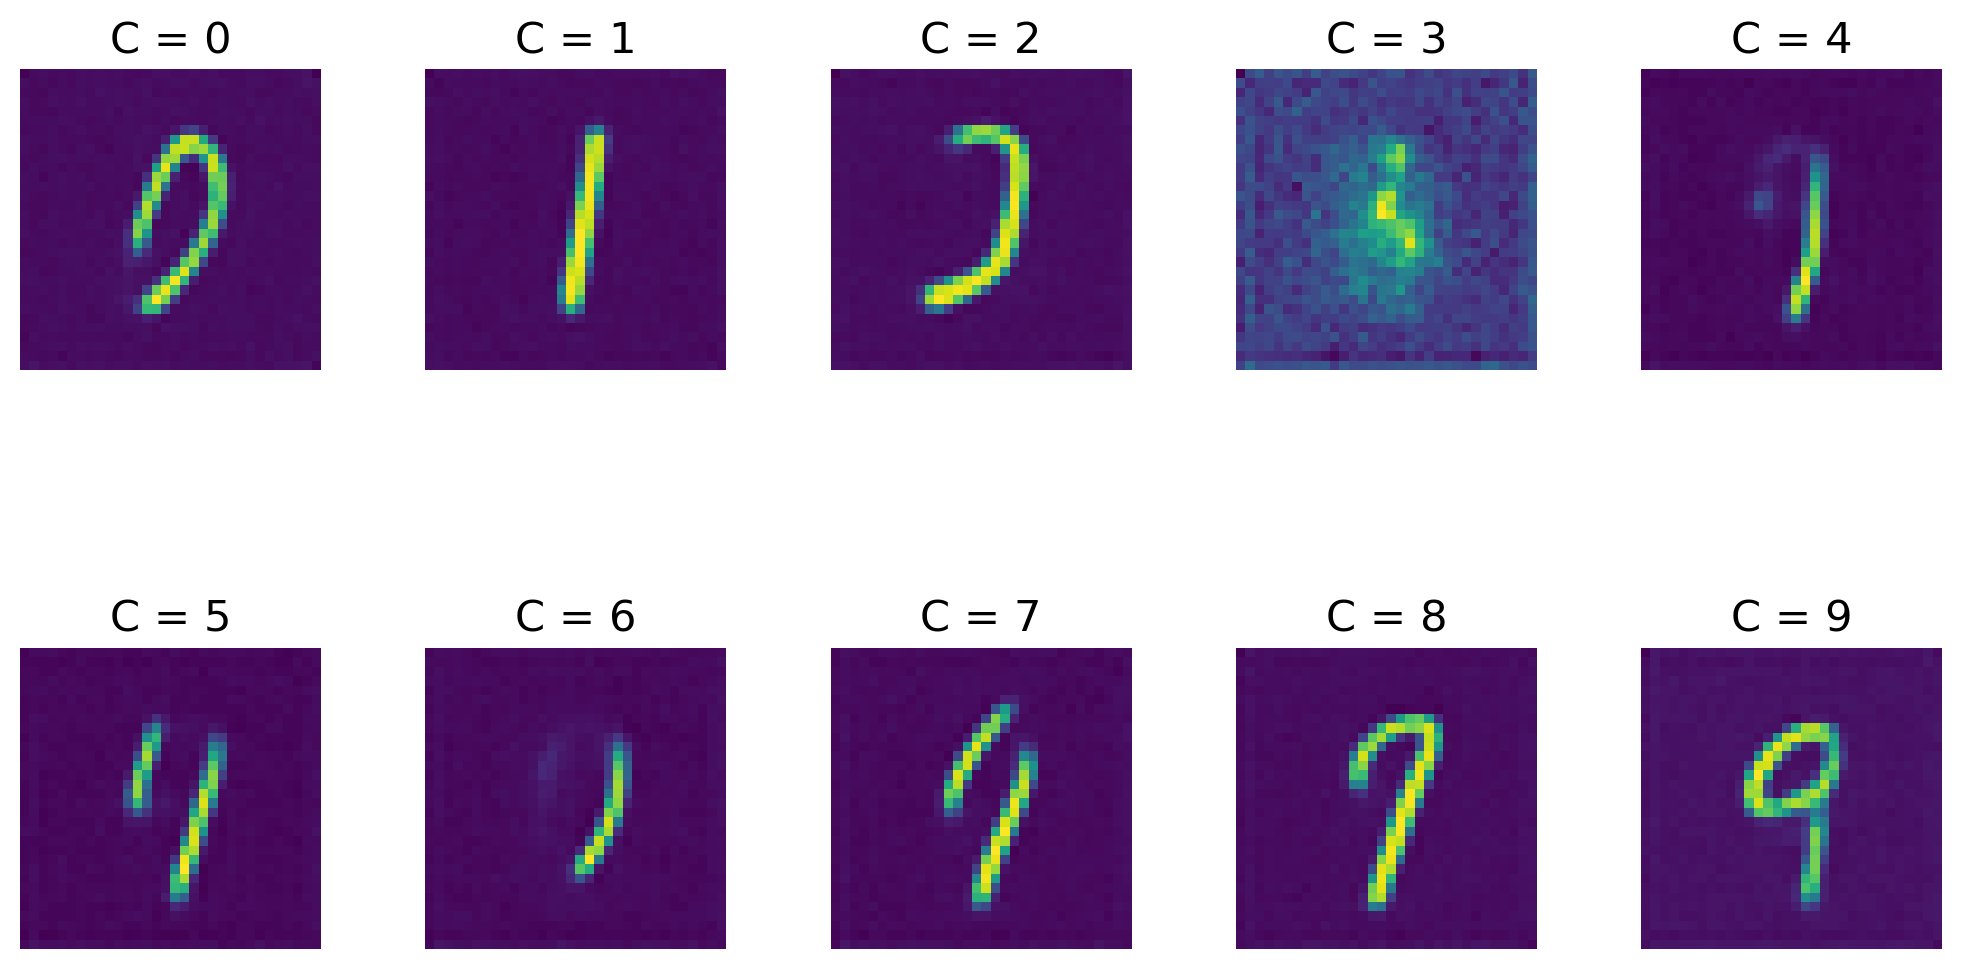

100%|██████████| 469/469 [00:15<00:00, 29.52it/s]


Loss:  0.012179612182080746


100%|██████████| 199/199 [00:00<00:00, 205.17it/s]


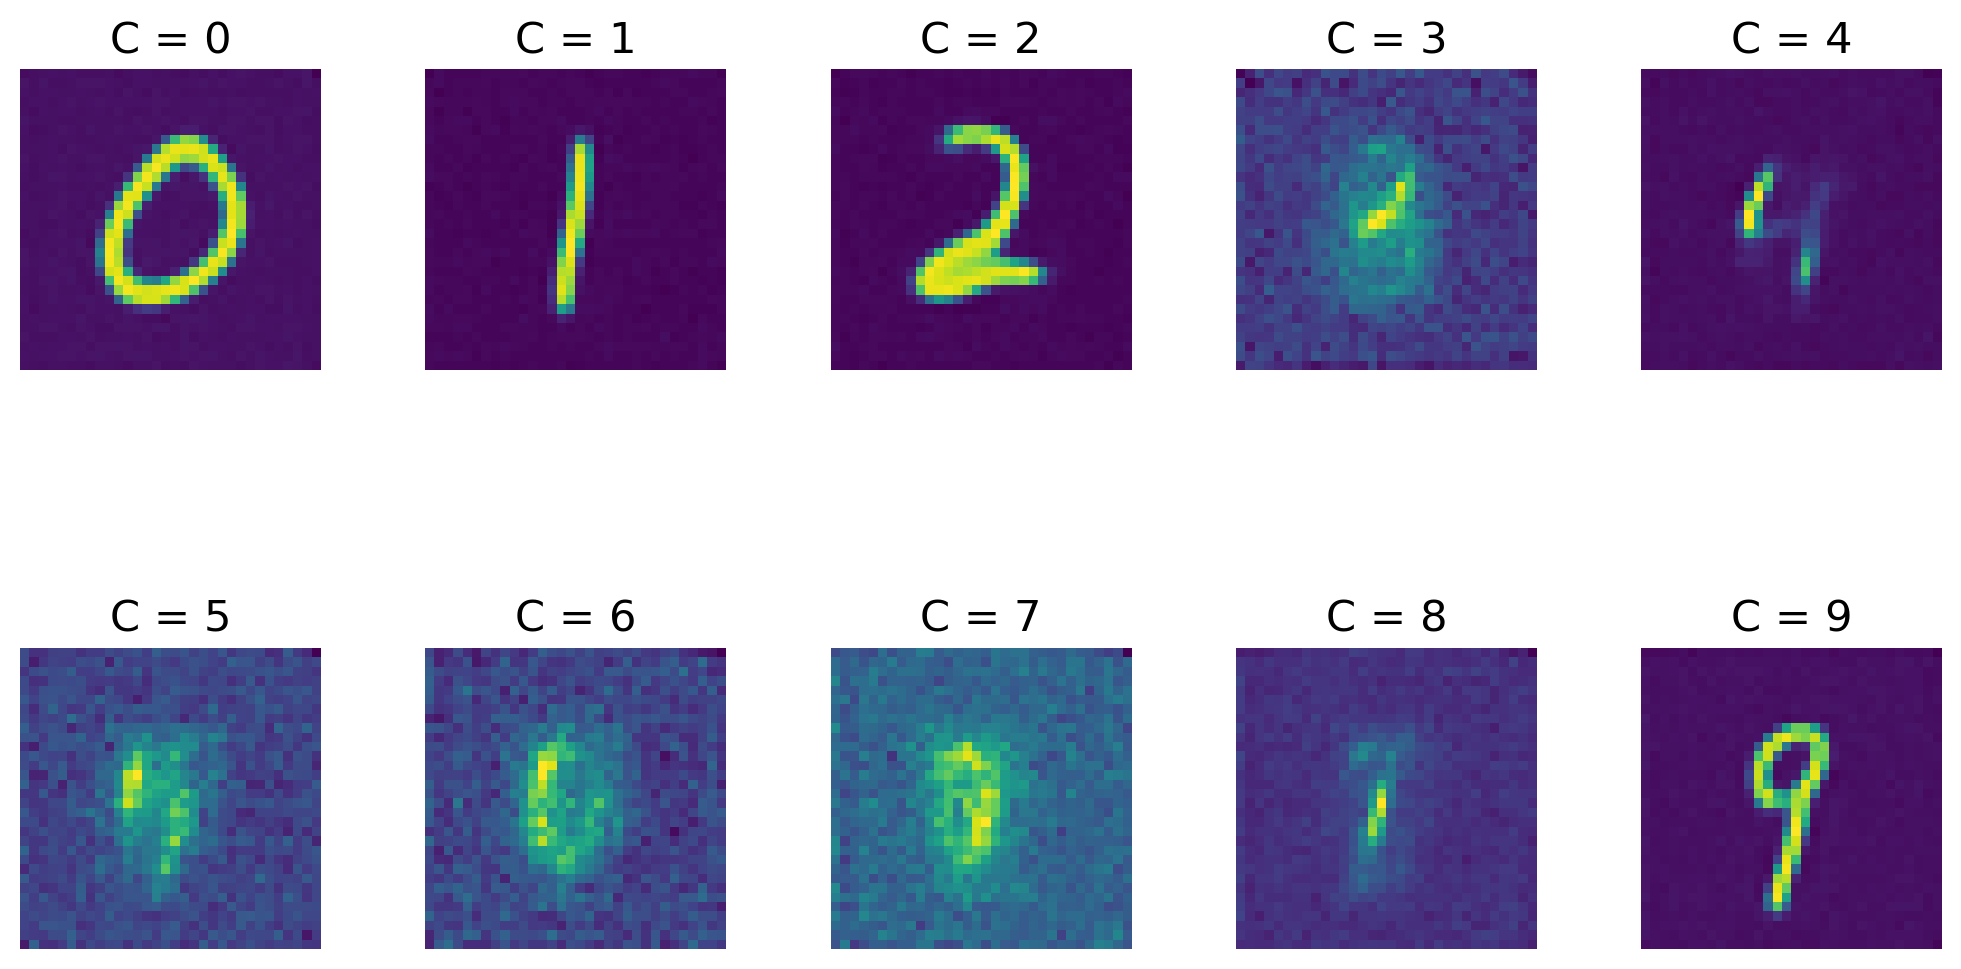

100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


Loss:  0.011413849890232086


100%|██████████| 199/199 [00:01<00:00, 198.36it/s]


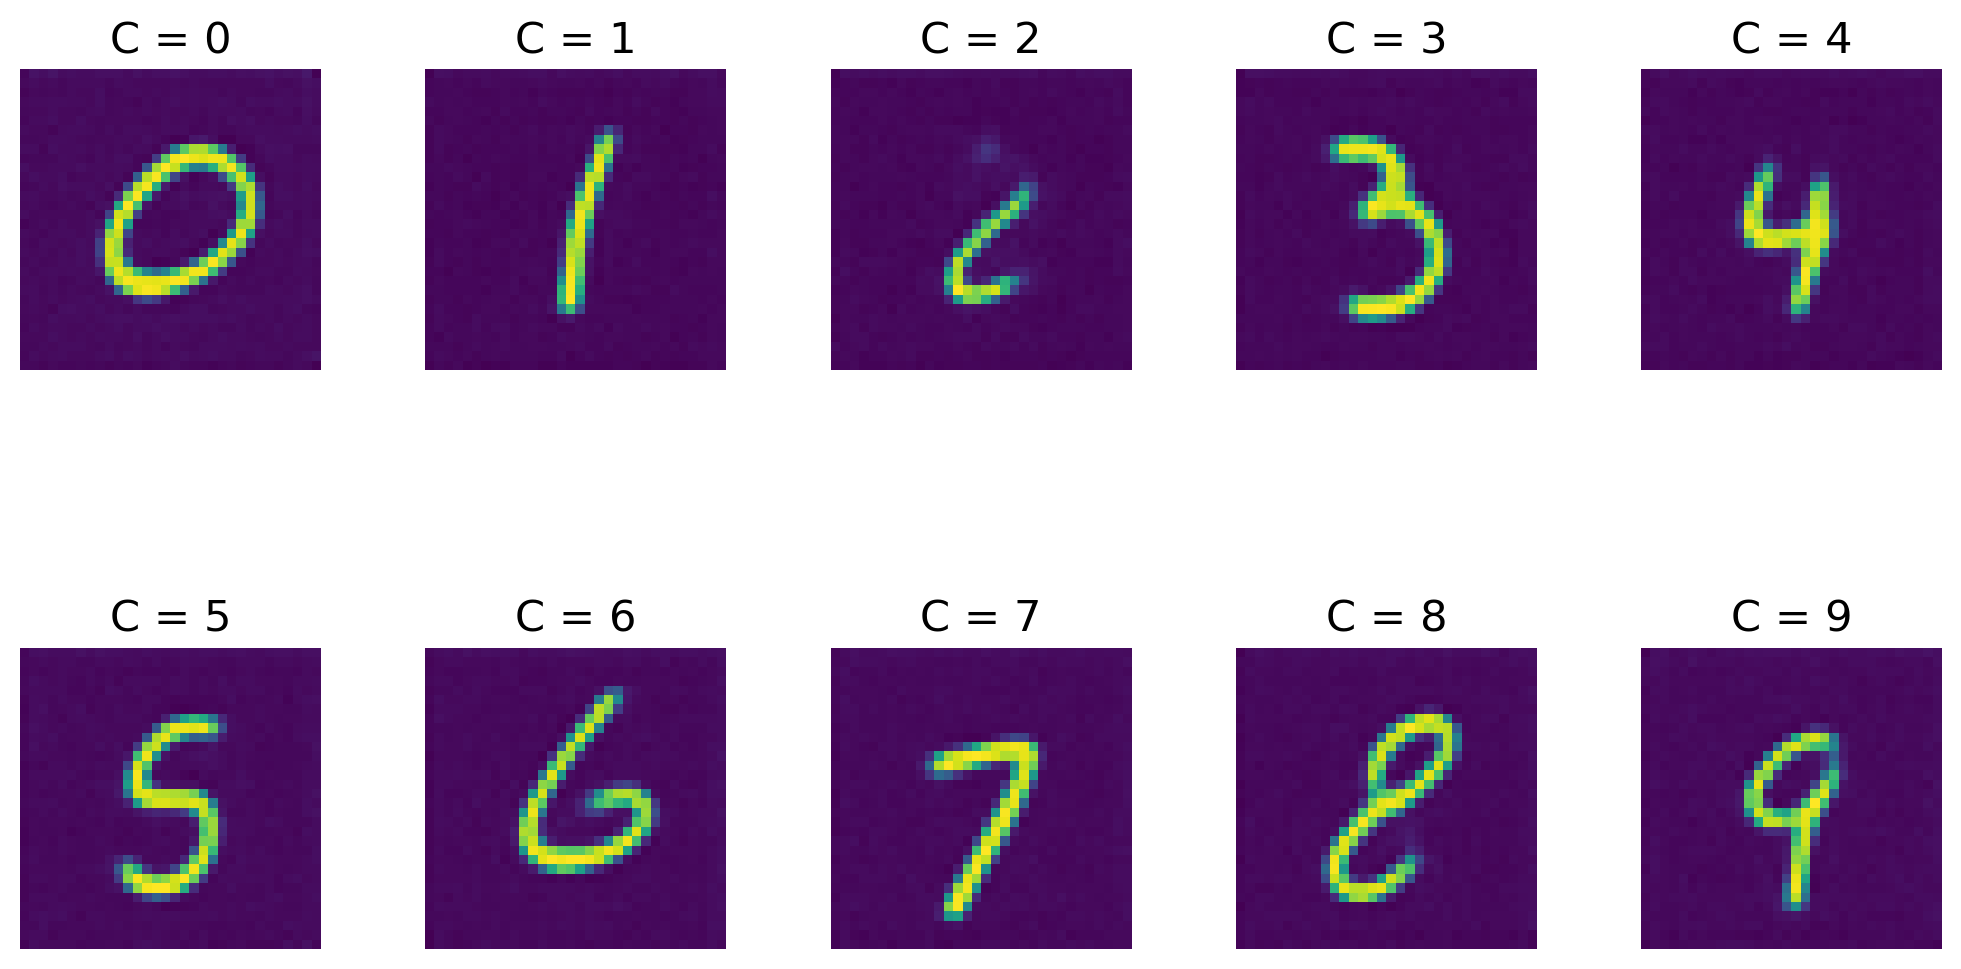

100%|██████████| 469/469 [00:16<00:00, 29.15it/s]


Loss:  0.01087260153144598


100%|██████████| 199/199 [00:01<00:00, 198.19it/s]


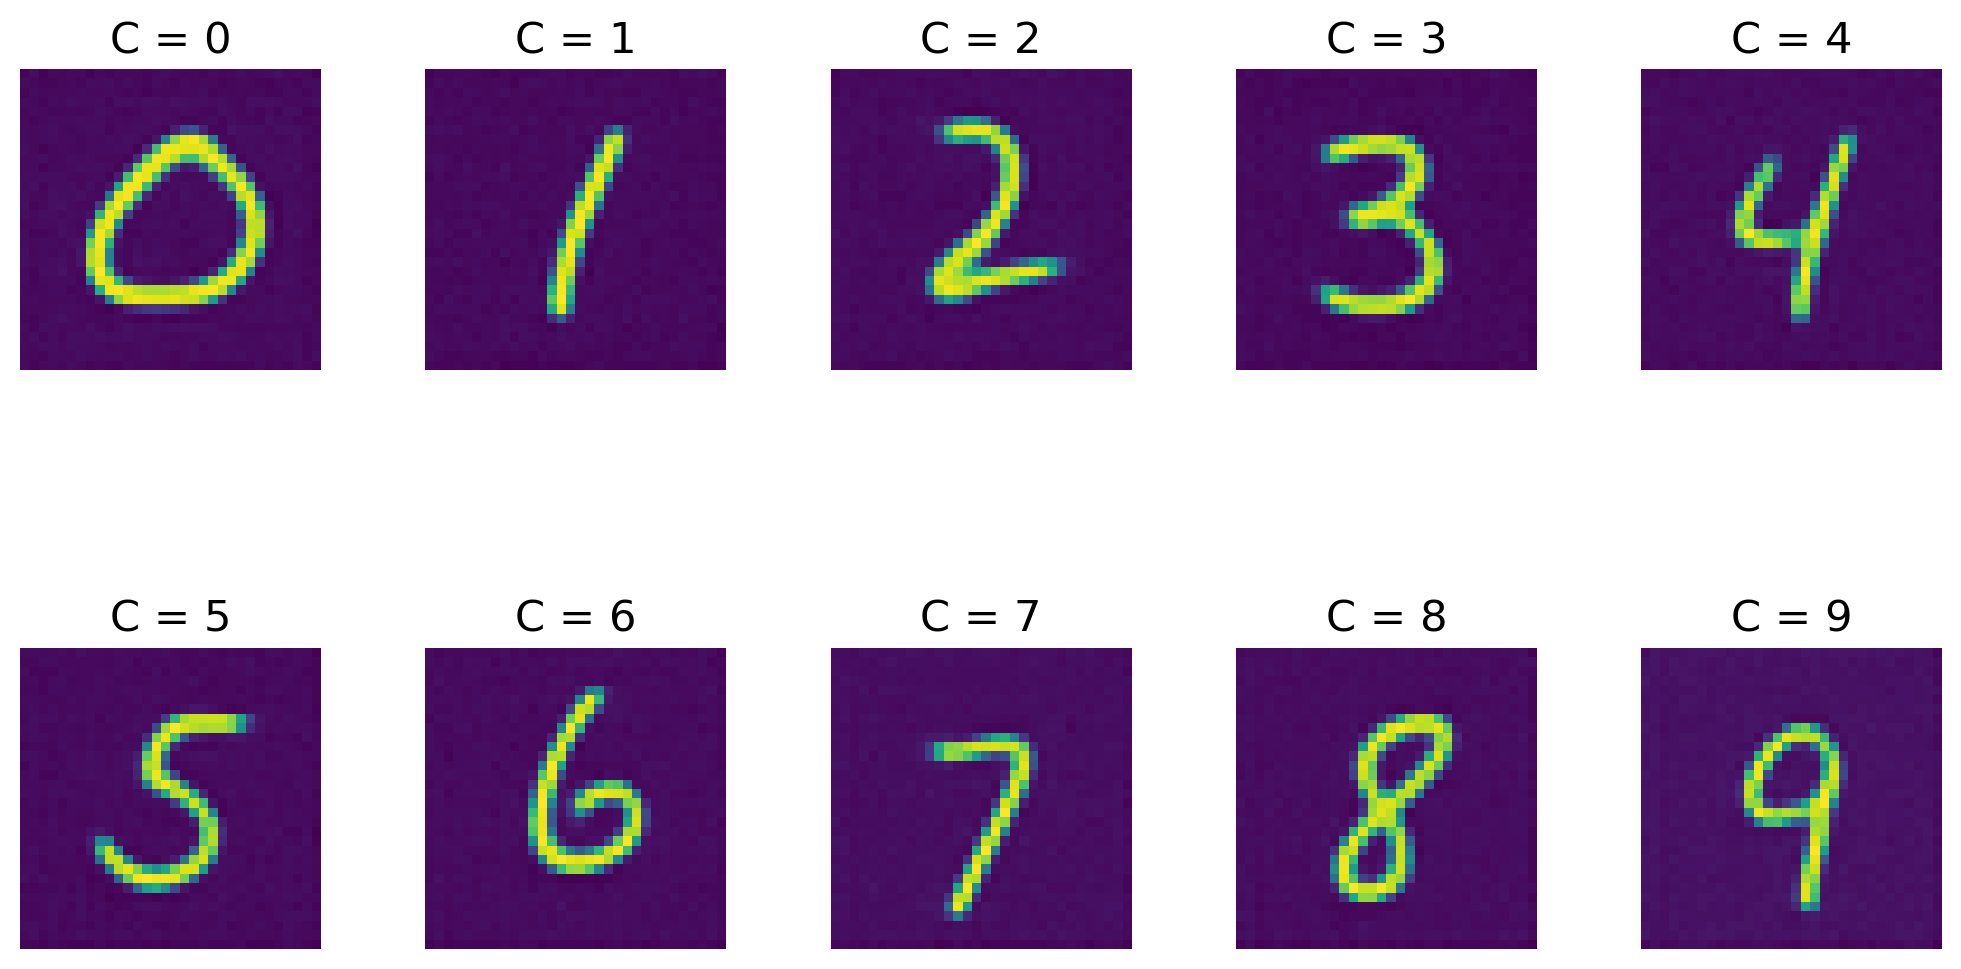

100%|██████████| 469/469 [00:15<00:00, 29.63it/s]


Loss:  0.012068341486155987


100%|██████████| 199/199 [00:01<00:00, 195.06it/s]


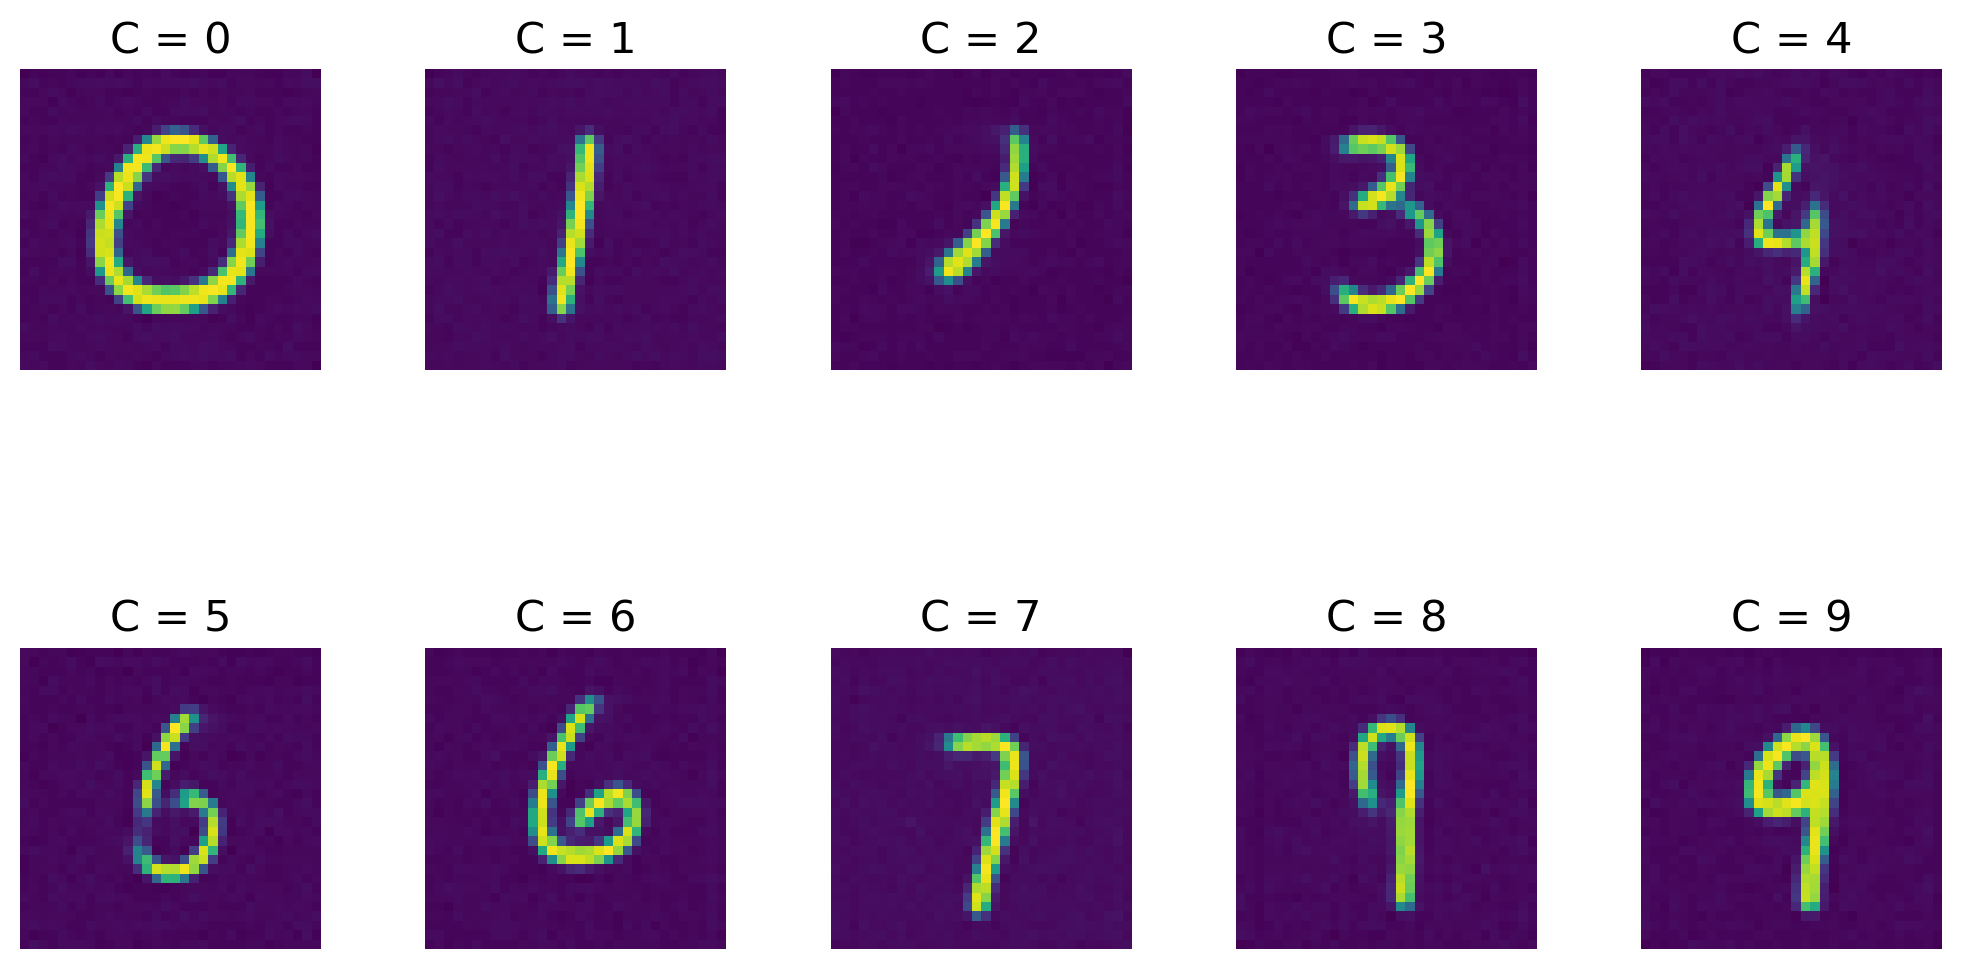

100%|██████████| 469/469 [00:16<00:00, 28.87it/s]


Loss:  0.011953448876738548


100%|██████████| 199/199 [00:01<00:00, 195.07it/s]


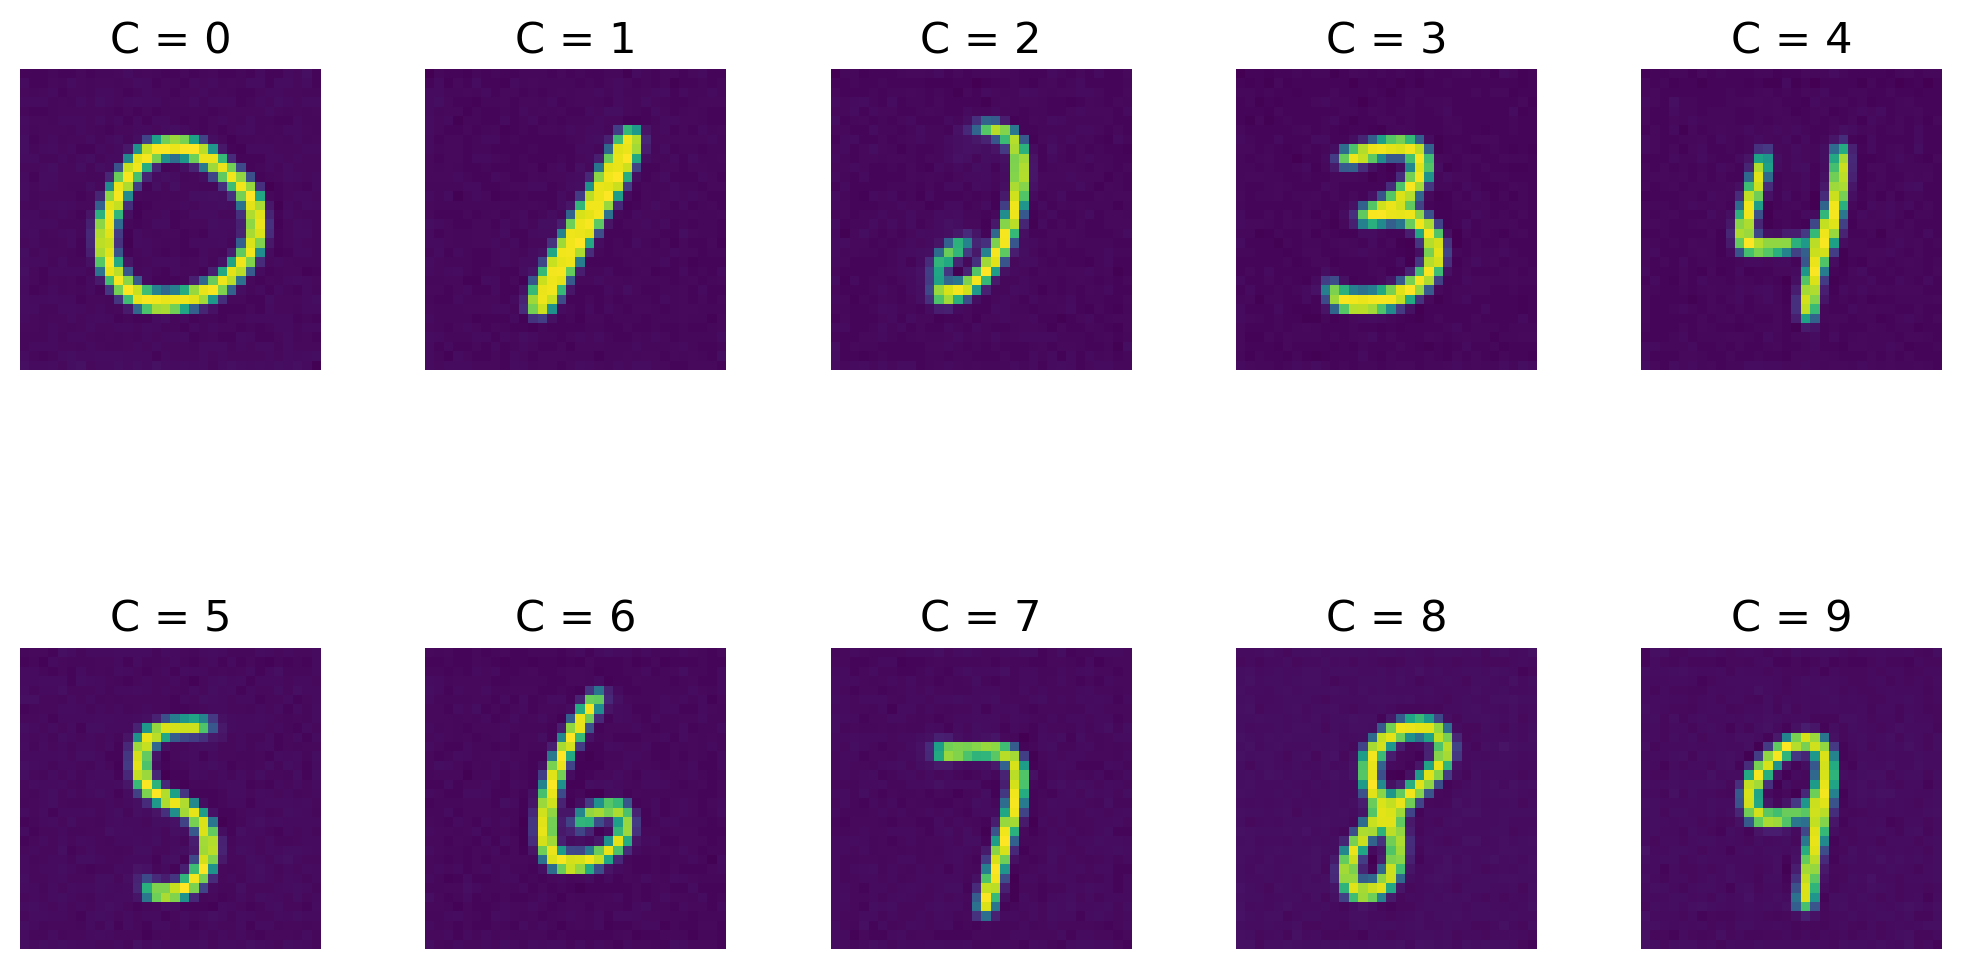

100%|██████████| 469/469 [00:15<00:00, 29.48it/s]


Loss:  0.011435667984187603


100%|██████████| 199/199 [00:00<00:00, 212.08it/s]


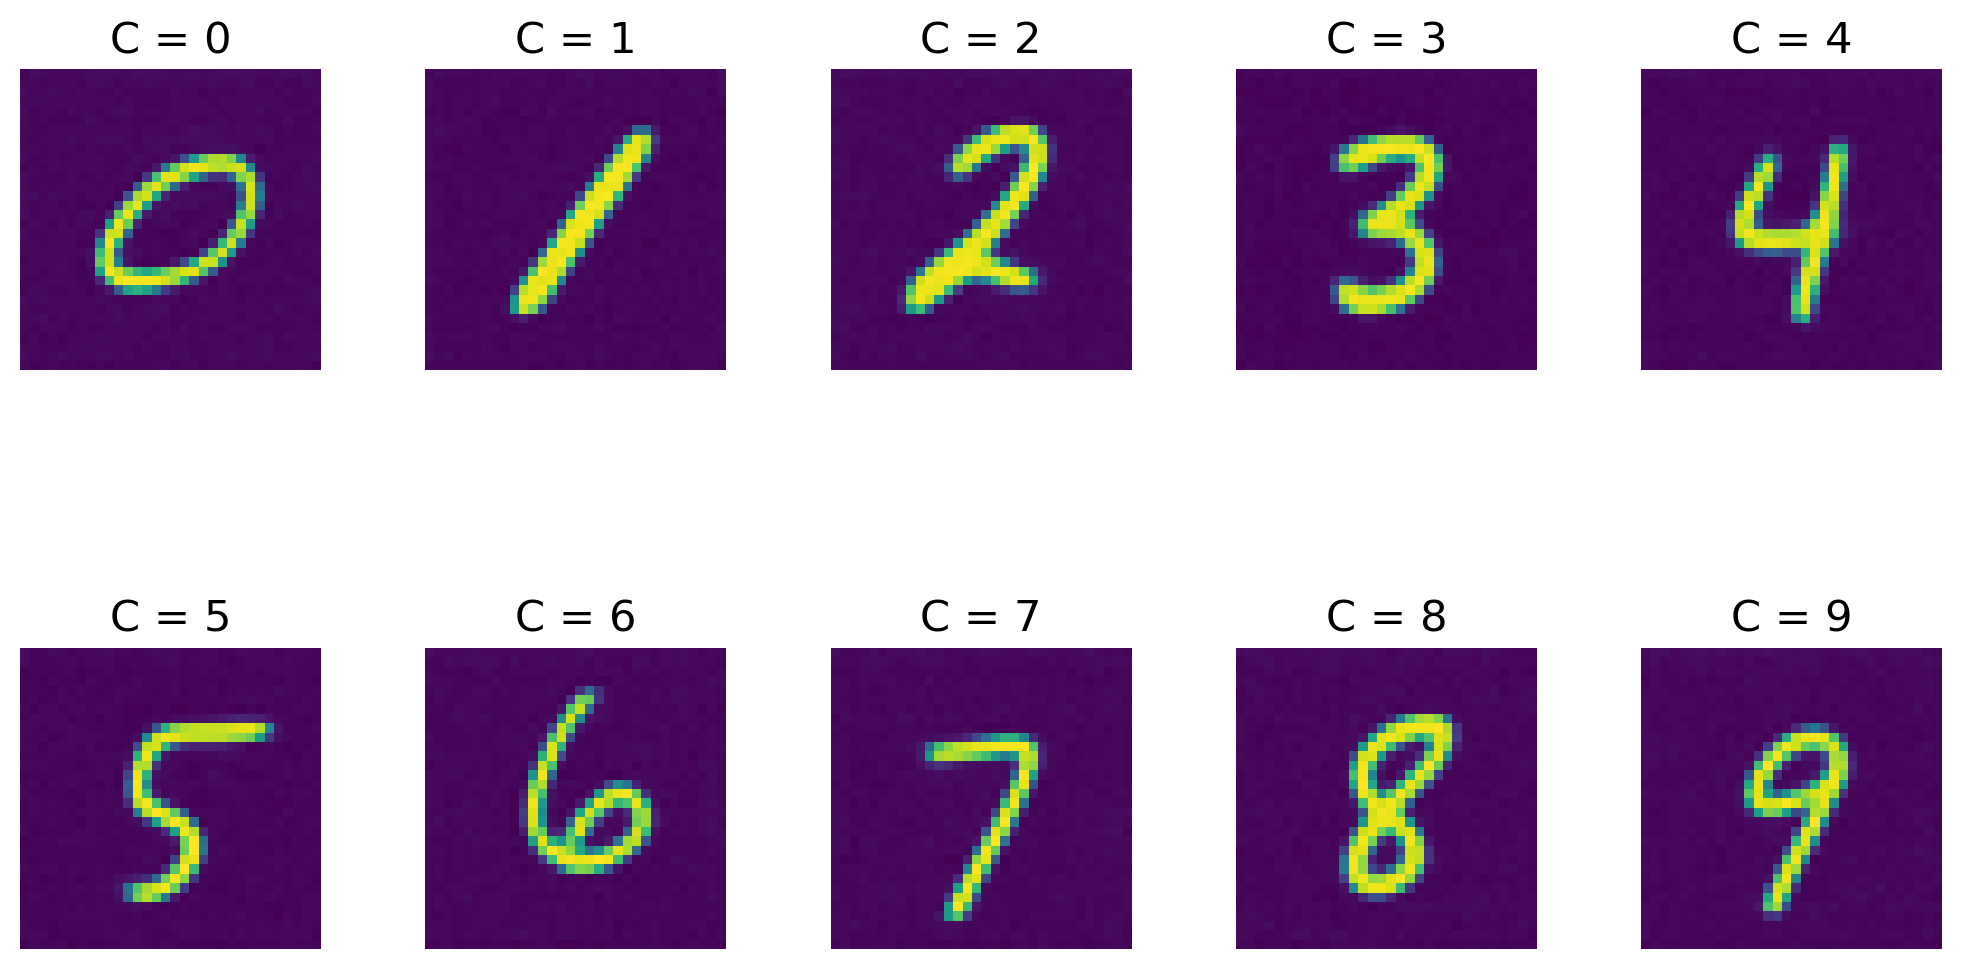

100%|██████████| 469/469 [00:15<00:00, 30.07it/s]


Loss:  0.011206105351448059


100%|██████████| 199/199 [00:00<00:00, 211.49it/s]


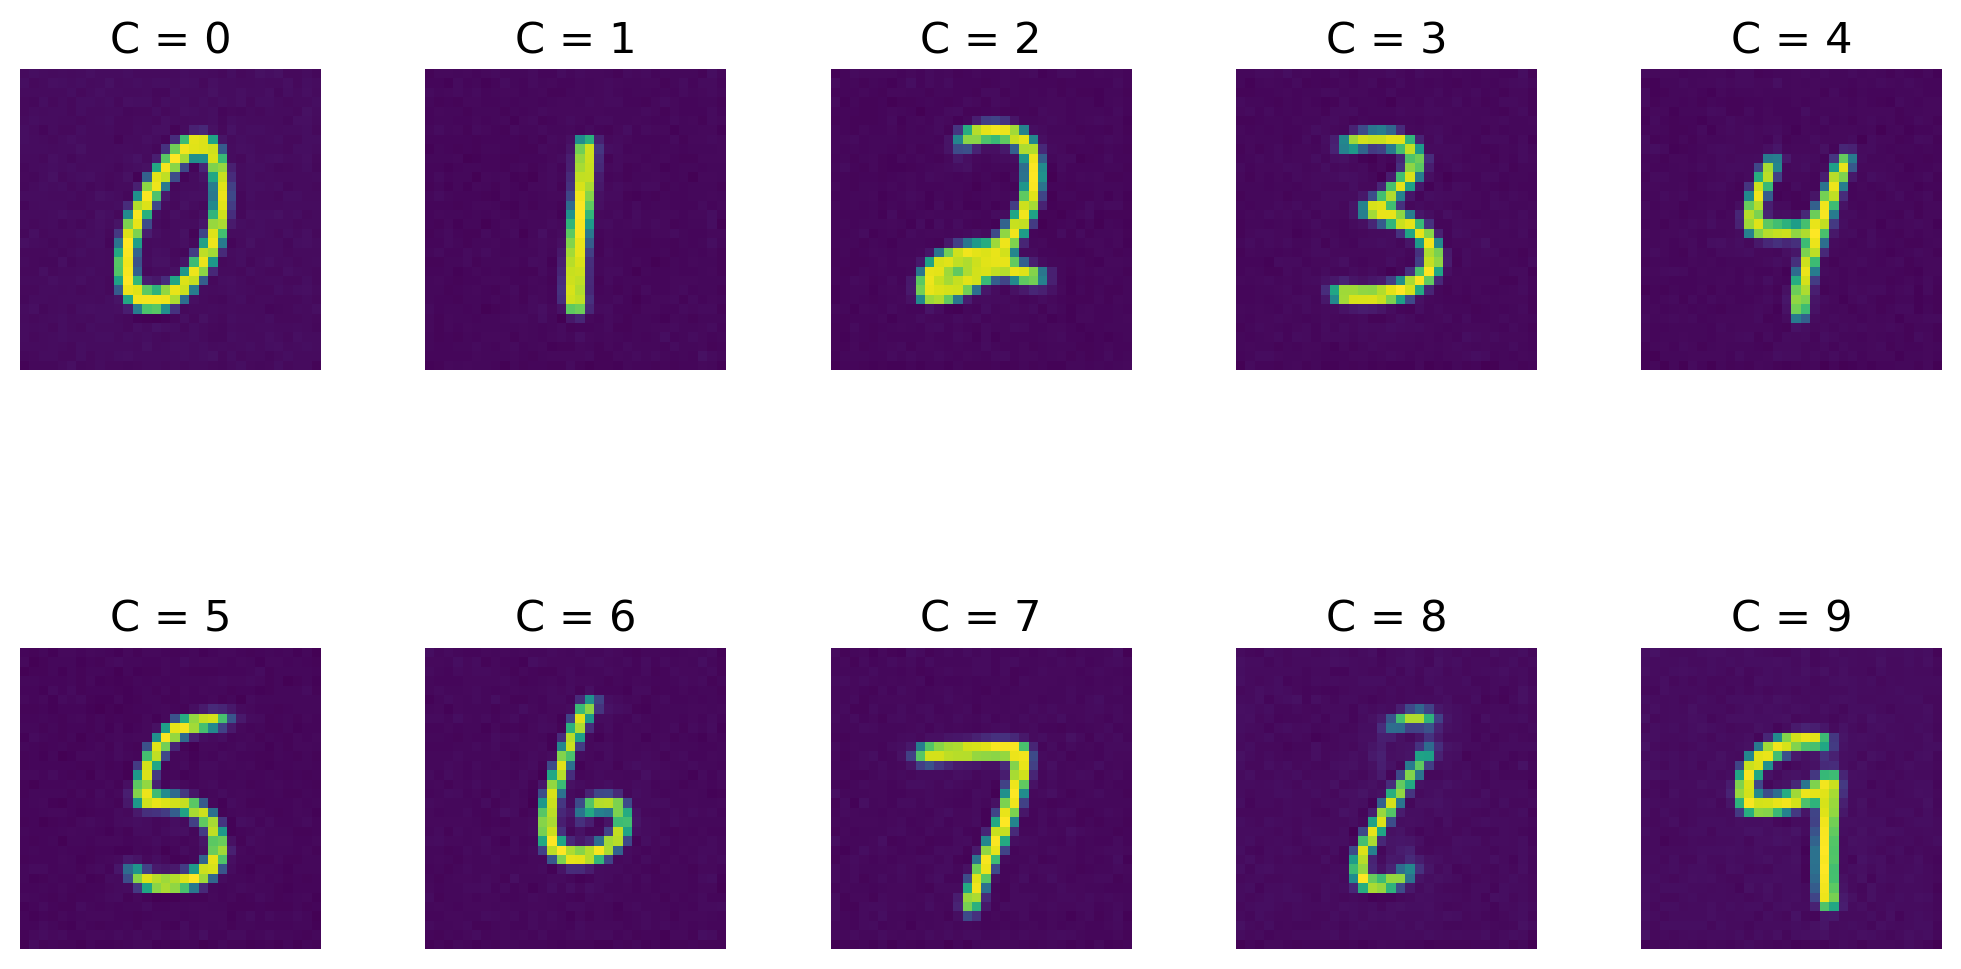

100%|██████████| 469/469 [00:15<00:00, 30.51it/s]


Loss:  0.011028437875211239


100%|██████████| 199/199 [00:00<00:00, 204.46it/s]


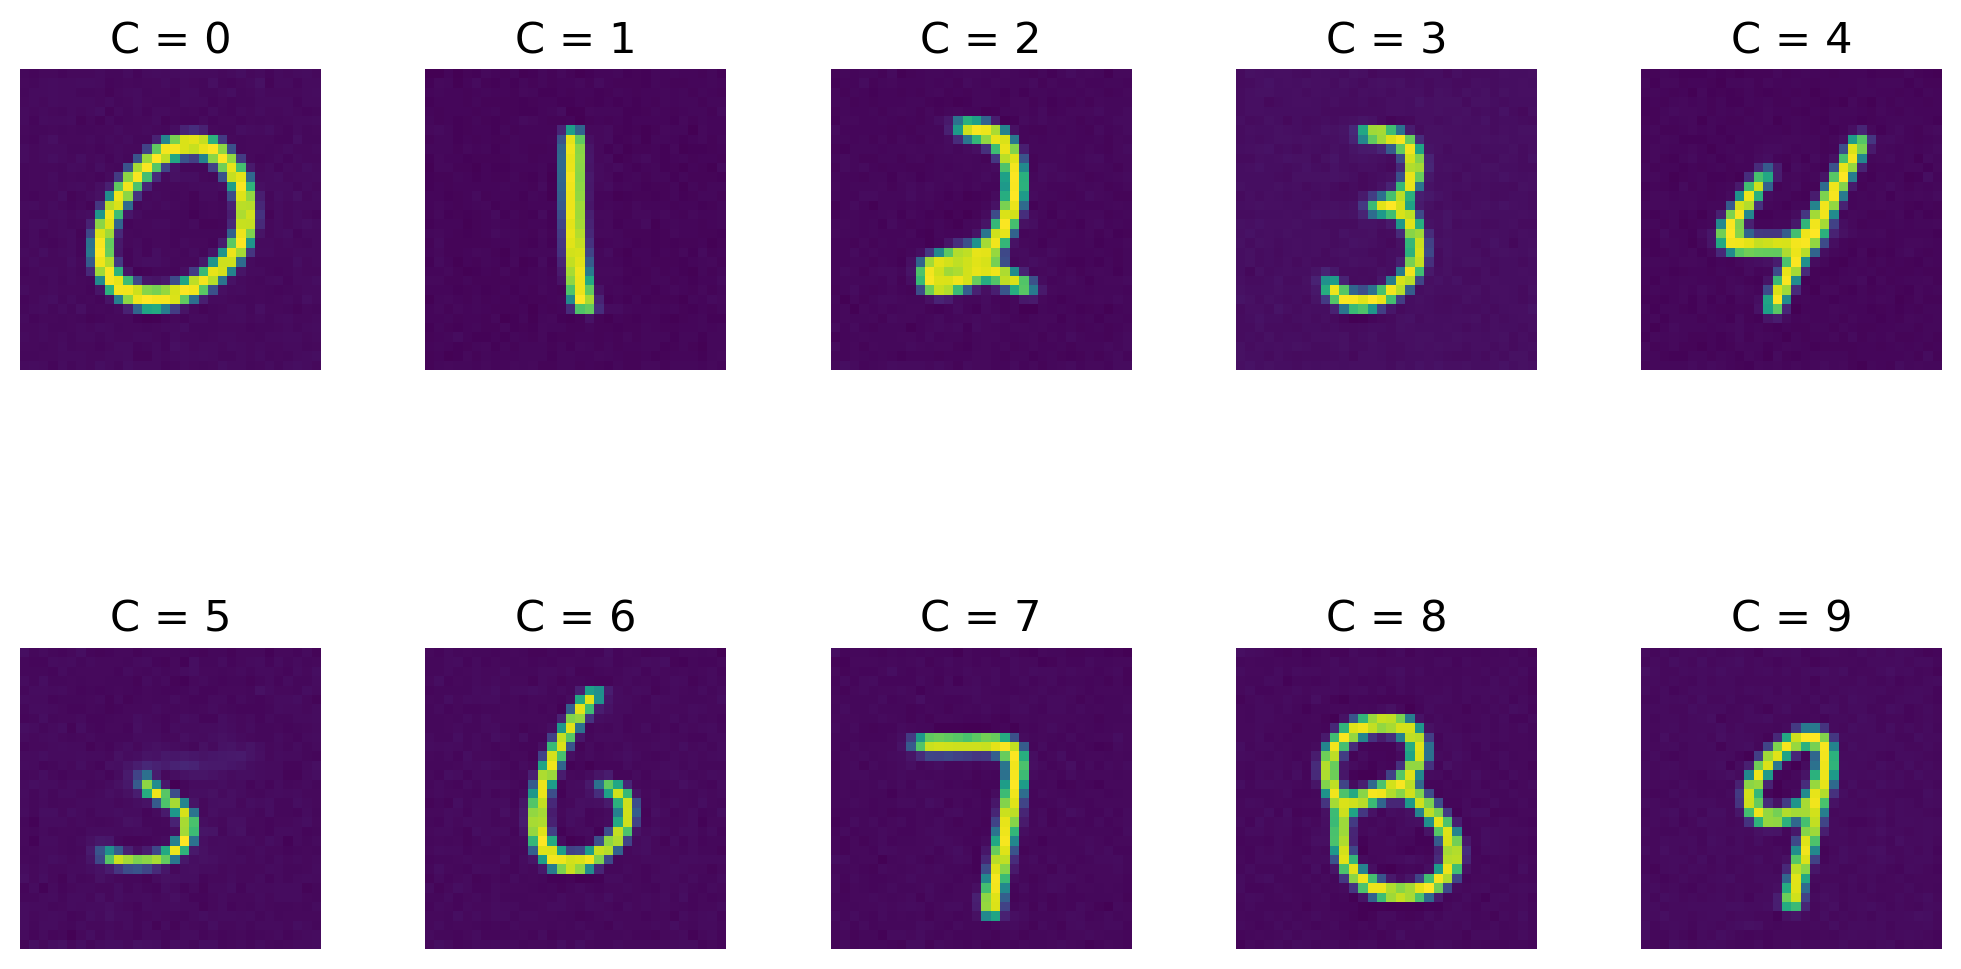

 15%|█▌        | 71/469 [00:02<00:13, 28.48it/s]


KeyboardInterrupt: 

In [86]:
for epoch in range(20):

    for x, c in tqdm(train_loader):

        # ------ Preprocessing -----
        #
        # Sampling uniformly diffusion steps
        diffusion_steps = torch.randint(0, T, (x.shape[0], 1))

        # Sampling noise
        noise = torch.normal(0, 1, x.shape)

        # Generating latent representations of the data
        z_t = model.generate_latent(x, noise, diffusion_steps)

        # Pushing to device-
        z_t, noise, diffusion_steps =  z_t.to(device), noise.to(device), diffusion_steps

        # Creation of the conditioning
        conditioning = c[:, None, None, None].expand(-1, 1, x.shape[2], x.shape[3]).to(device)

        # Adding the conditioning
        z_t = torch.cat([conditioning, z_t], dim = 1)

        # ----- Training -----
        #
        # Prediction
        noise_pred = model.predict(z_t, diffusion_steps)

        # Loss
        loss = torch.pow(noise_pred - noise, 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Information over terminal
    print("Loss: ", loss.item())
    samples = model.generate_samples(steps = T - 1).cpu()
    plt.figure(figsize = (10, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(f"C = {i}")
        plt.imshow(samples[i].squeeze().numpy(), cmap='viridis')
        plt.tight_layout()
        plt.axis('off')
    plt.show()


100%|██████████| 25/25 [00:00<00:00, 211.41it/s]


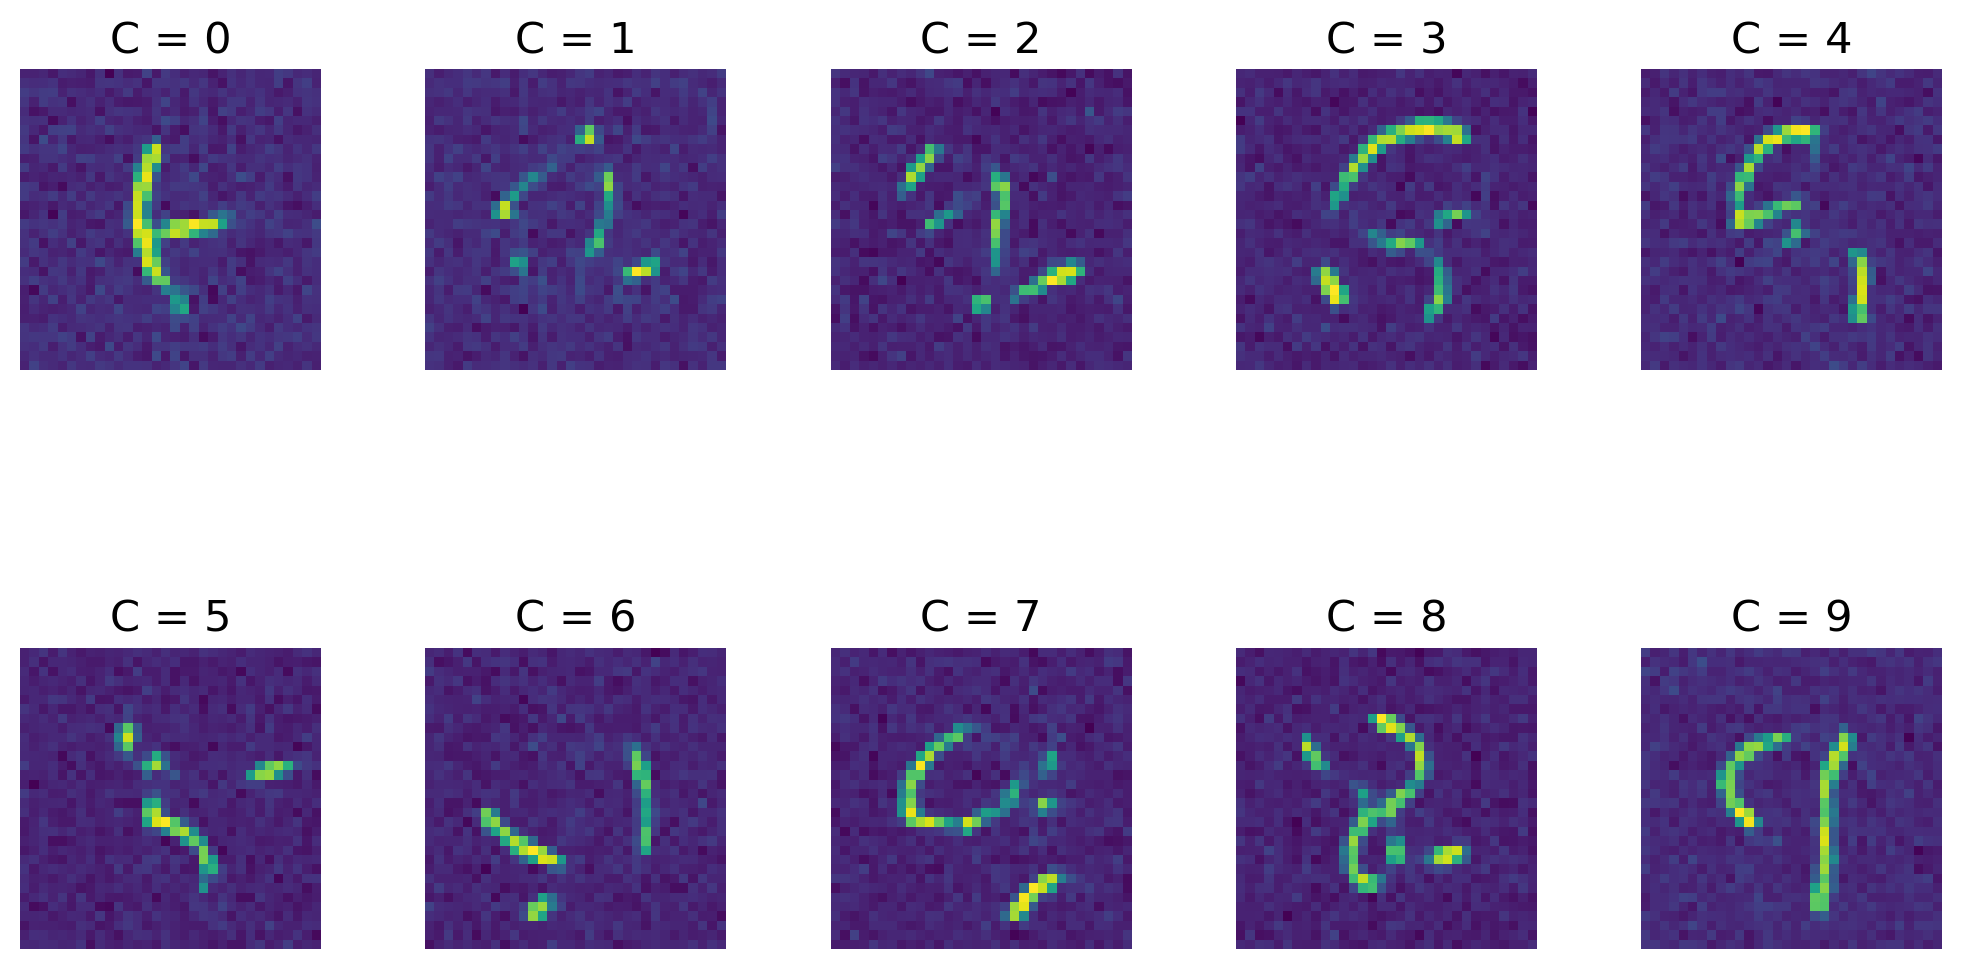

100%|██████████| 50/50 [00:00<00:00, 212.84it/s]


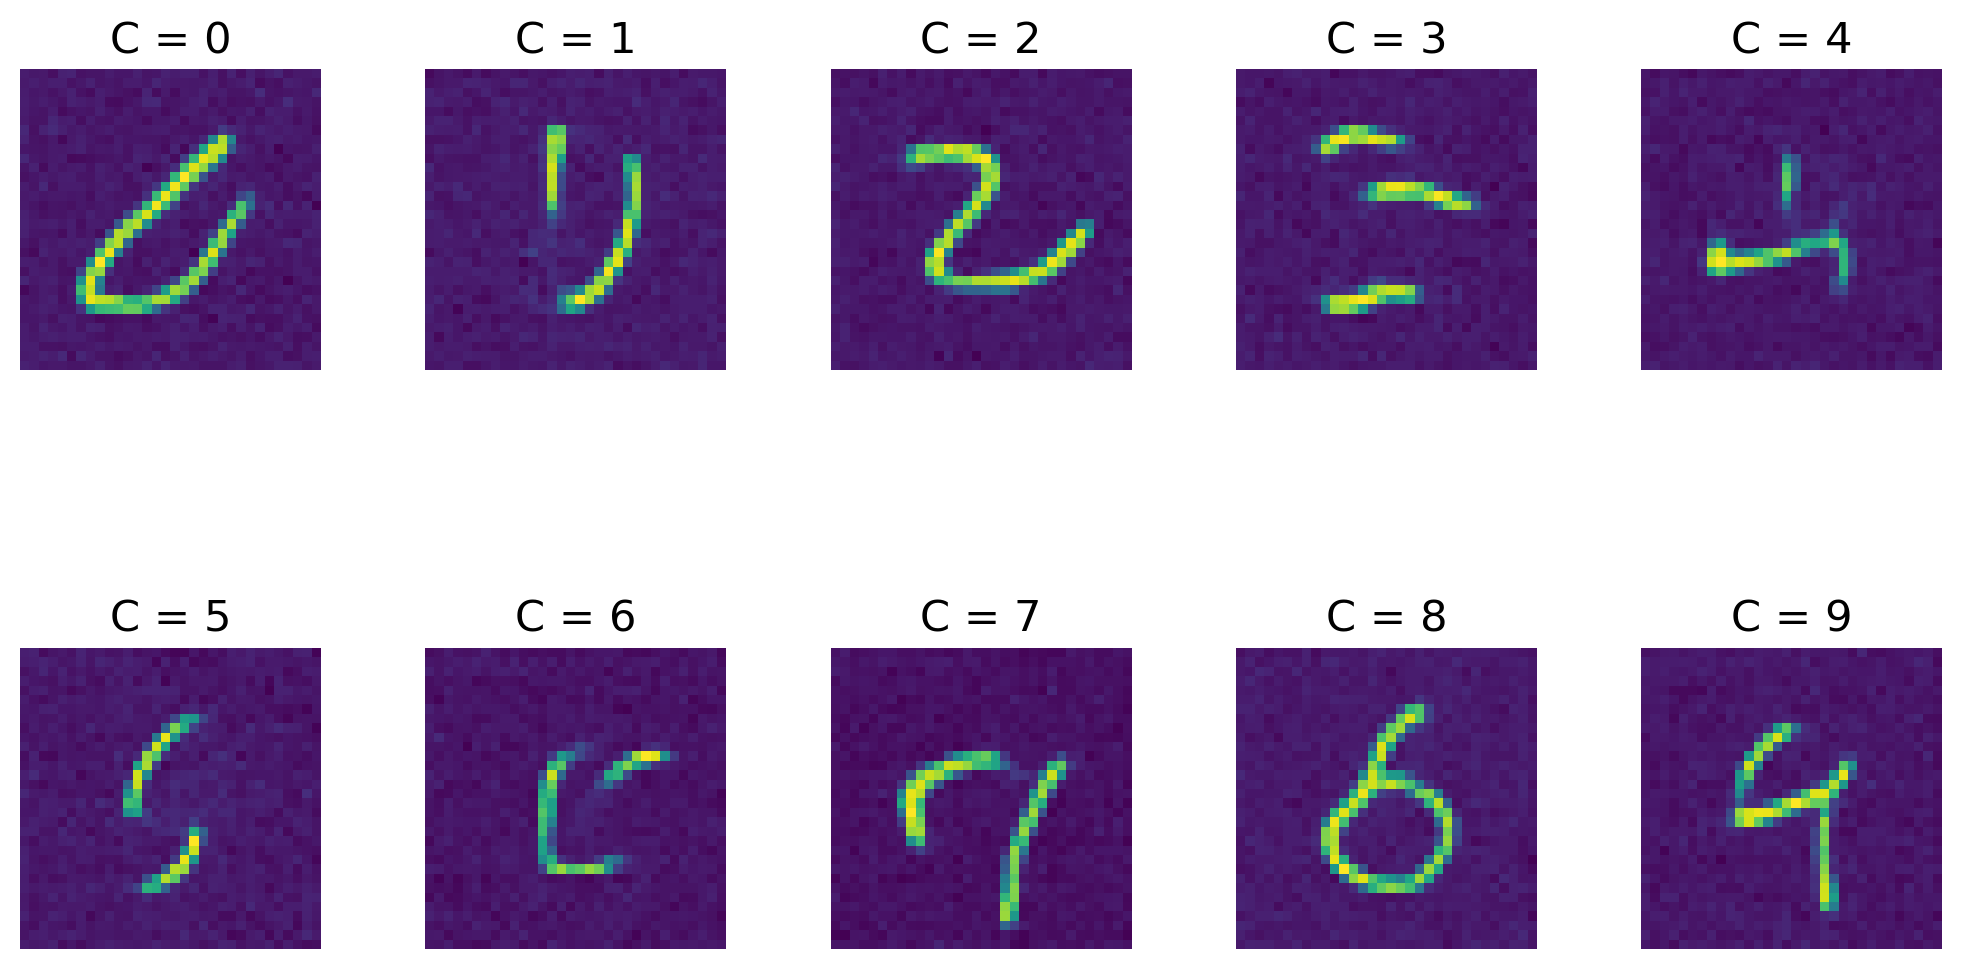

100%|██████████| 100/100 [00:00<00:00, 213.62it/s]


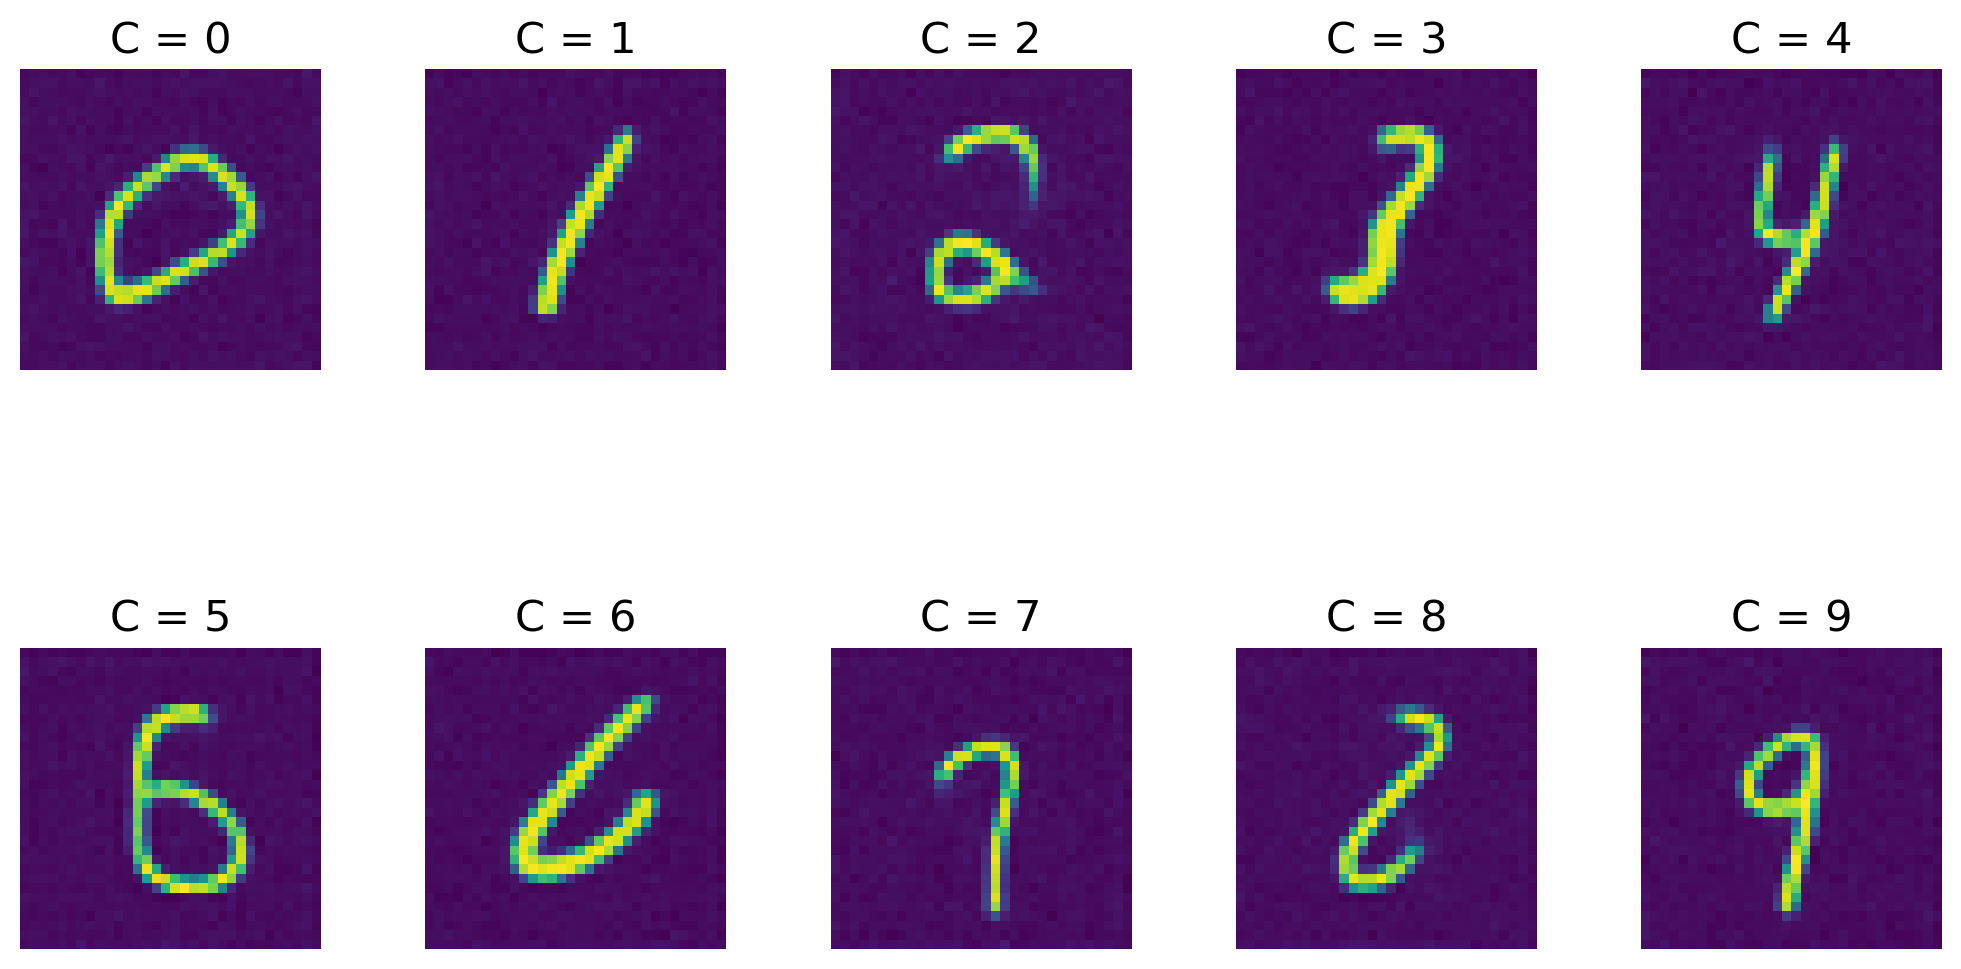

100%|██████████| 125/125 [00:00<00:00, 212.93it/s]


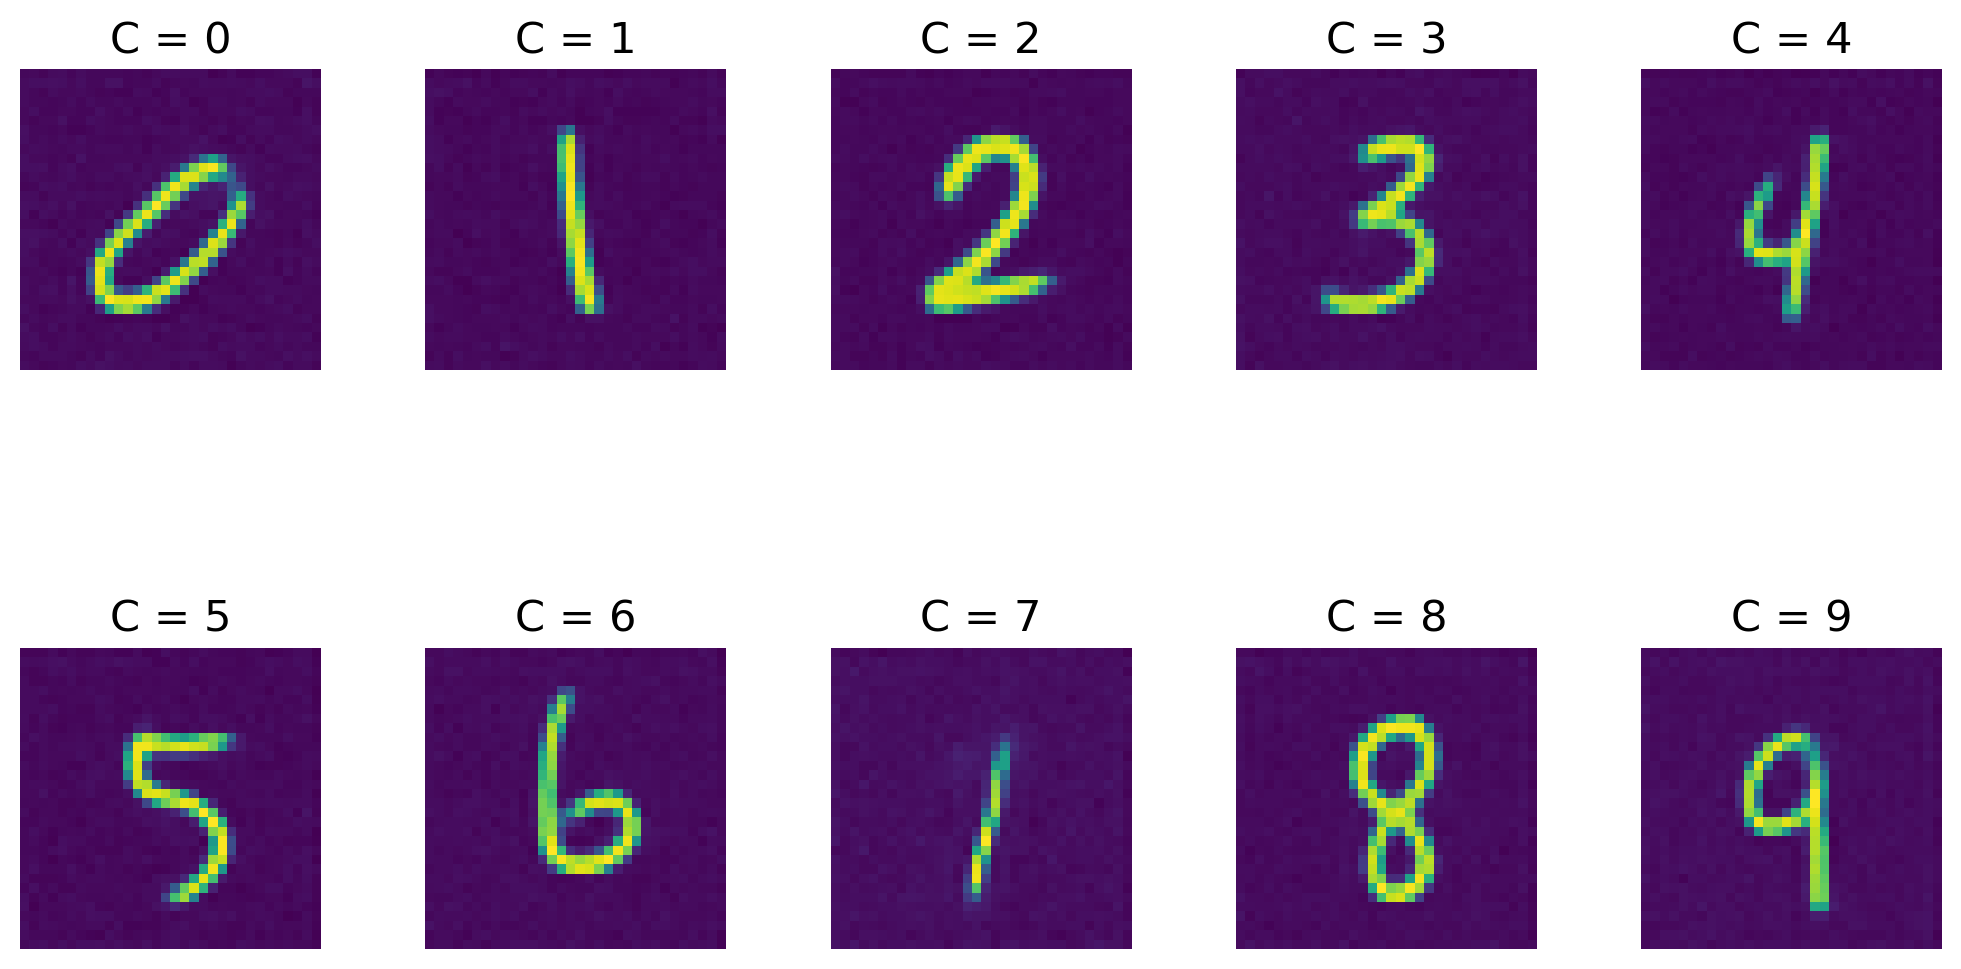

100%|██████████| 150/150 [00:00<00:00, 214.59it/s]


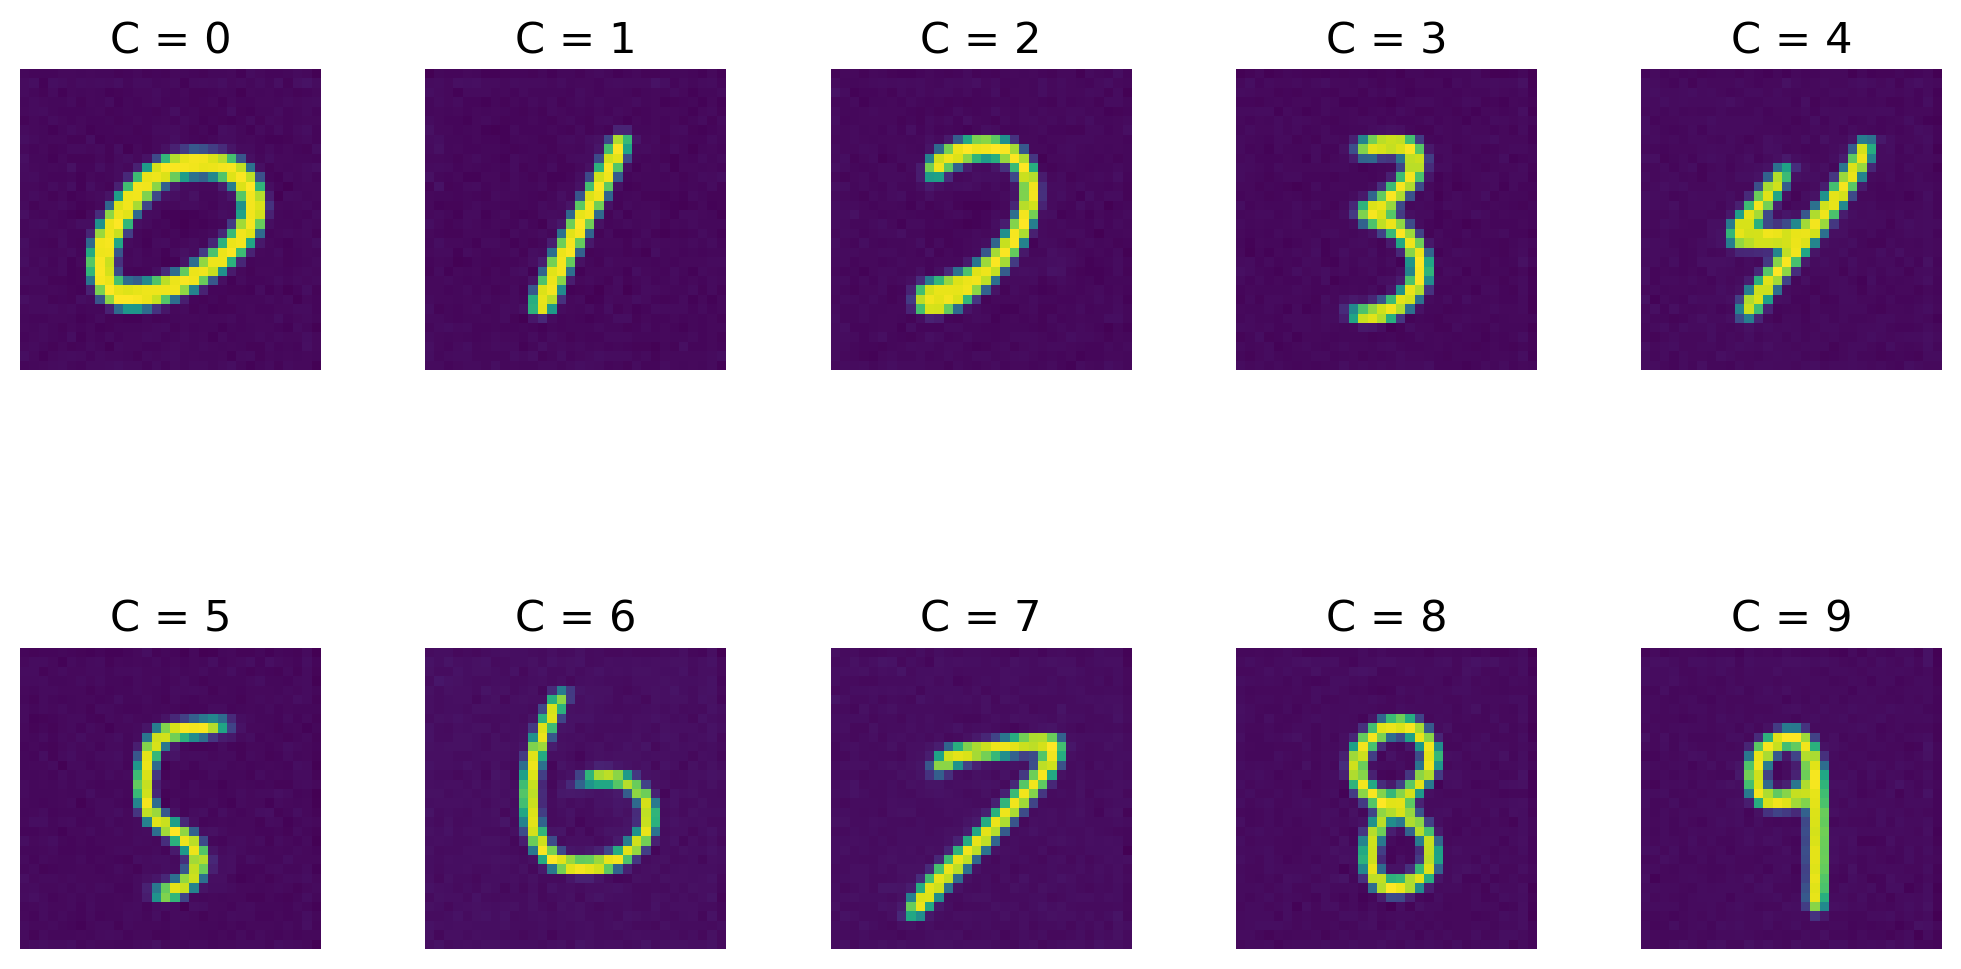

100%|██████████| 175/175 [00:00<00:00, 215.16it/s]


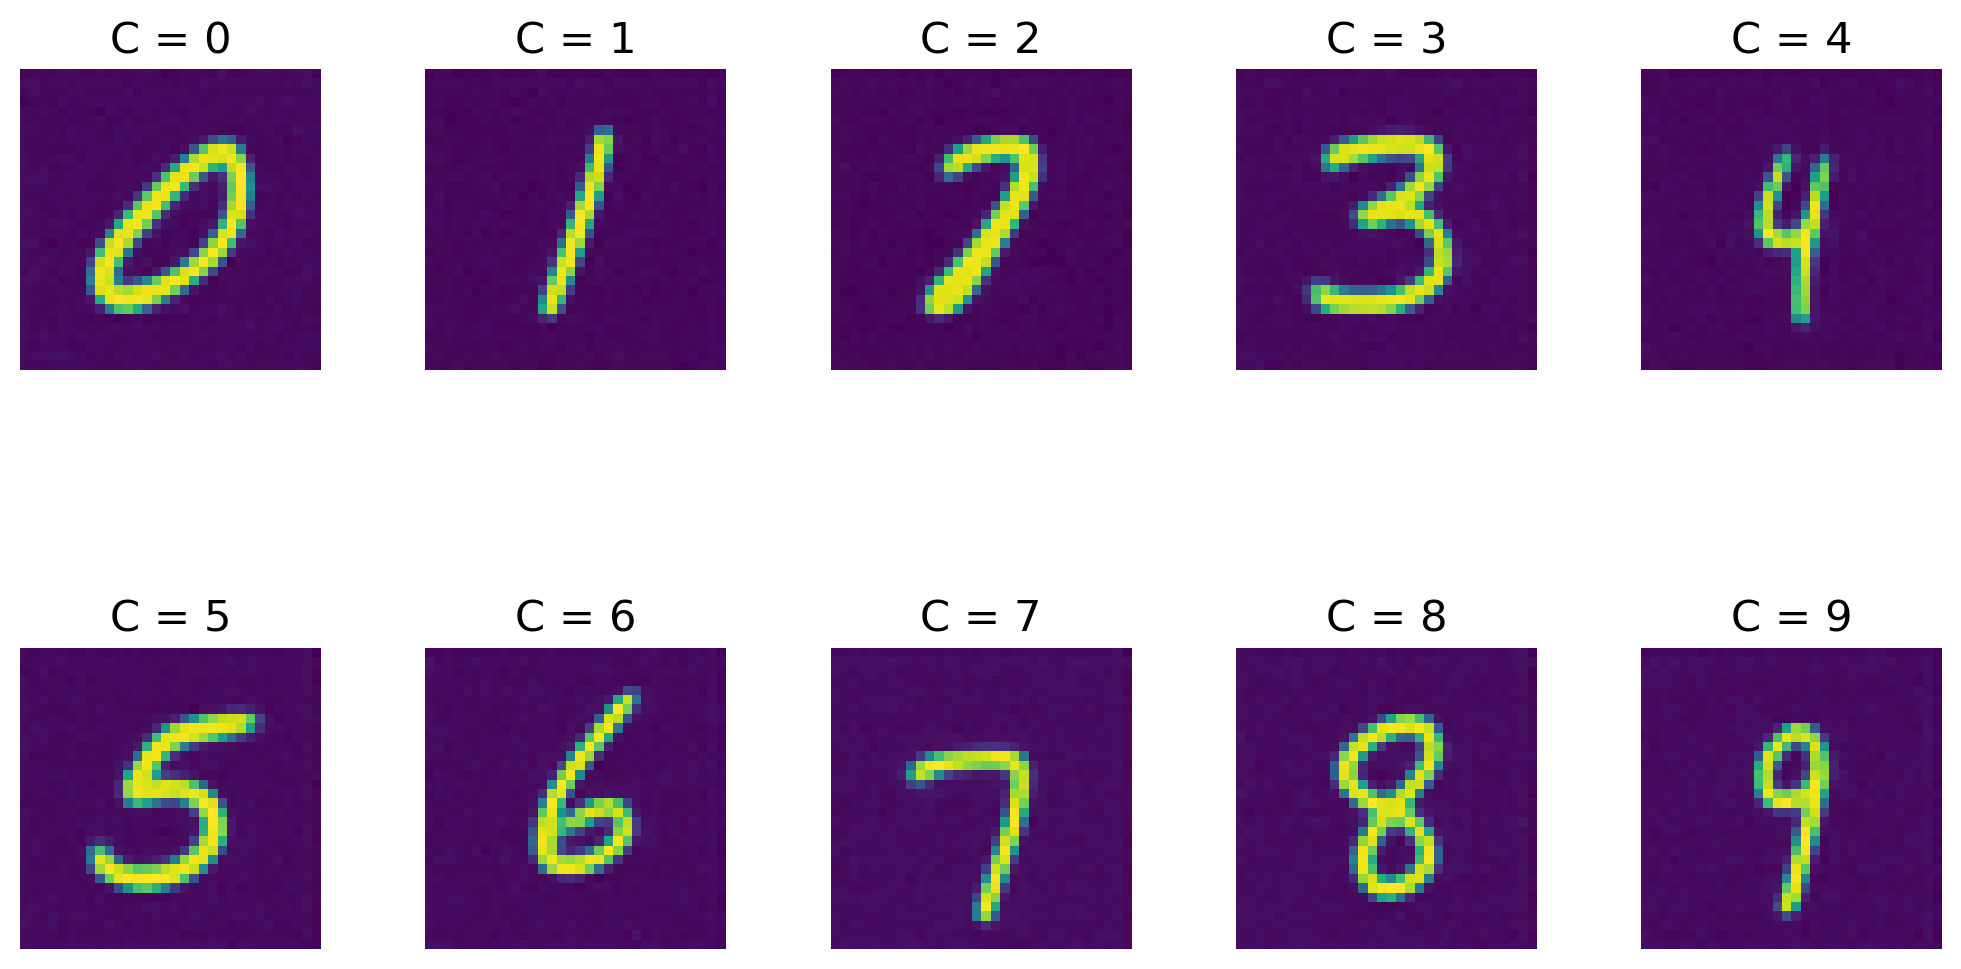

In [87]:
for steps in [25, 50, 100, 125, 150, 175]:
    samples = model.generate_samples(steps = steps).cpu()
    plt.figure(figsize = (10, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(f"C = {i}")
        plt.imshow(samples[i].squeeze().numpy(), cmap='viridis')
        plt.tight_layout()
        plt.axis('off')
    plt.show()